# Цели обучения в Яндекс Практикум - результаты опроса студентов

## Ссылки на материалы

 1. [**Аналитический проект** (Colab)](https://colab.research.google.com/drive/1wGBNEdgIUK2HEY4xHKIQrLr7NYeFoR0z?usp=sharing)
 2. [**Презентация** (Figma)](https://www.figma.com/file/0o6SPvvrgdUrM6RITumpaB/Хакатон-Яндекс-Практикум_март-2023_команда-5?node-id=0-1&t=LULtkMV4i8WnWj6i-0)
 3. [**Архив с графиками в .SVG**](https://disk.yandex.ru/d/e4XCqVfQQdMPfQ)

## План проекта

 1. [**Введение**](#intro)   
 2. [**Описание данных**](#intro_1)   
 3. [**Загрузка данных**](#data_load)   
 4. [**Предобработка данных**](#data_clean)   
     4.1. [Пропуски и дубликаты в данных](#data_clean_1)   
     4.2. [Удаление лишних столбцов](#data_clean_2)   
     4.3. [Преобразование и соединение таблиц и обработка итоговой таблицы](#data_clean_3)   
 5. [**Исследовательский анализ**](#eda)   
     5.1. [Матрица корреляций](#eda_1)   
     5.2. [Основные признаки датасета](#eda_2)   
     5.3. [Ответы студентов на вопросы](#eda_3)   
     5.4. [Запросы студентов](#eda_4)   
     5.5. [Текстовые ответы](#eda_5)   
     5.6. [Особенности сегментов](#eda_6)   
     5.7. [Показатели в разрезе профессий](#eda_7)  
     5.8. [Портреты основных профессий](#eda_8)  
 6. [**Выводы**](#concl)   

## 1. Введение <a name="intro"></a>

**Отрасль и направления деятельности:** EdTech, сервис-онлайн образования

**О проекте:** Создание и оформление отчёта целей обучения студентов Яндекс Практикума для презентации топ-менеджменту Яндекс Практикума.

**Задачи отчёта:**

* определить нормальные и найти аномальные показатели
* определить коррелирующие параметры, построить портреты студентов, сравнить их, чтобы выделить значимые закономерности
* сегментировать студентов (по 2м и более показателям), выявить особенности сегментов
* сформулировать на основе данных гипотезы по улучшению выстраивания помощи студентам в достижении их целей,
* оформить выводы и гипотезы аналитиков с помощью инструментов фигмы для презентации руководству Яндекс Практикума.

## 2. Описание данных <a name="intro_1"></a>

data_goals_answers
* question_title — текст вопроса
* question_type — тип вопроса
* user_id — уникальный id пользователя
* user_answer — ответ пользователя на вопрос
* answer_date — время ответа
* answer_id — id ответа
* cohort, current_cohort — начальная и текущая когорта студента
* course_name, topic_name, lesson_name — курс, тема и урок, на котором студент отвечает на вопрос
   У нас значения должны быть Трудоустройство-Трудоустройство-Цель обучения, т.к. мы изучаем именно это
* original_segment, current_segment — b2c/b2b/b2g — из какого сегмента был/стал студент — сам является клиентом, его обучение оплачивается бизнесом или государством
* profession_name — код профессии
* statement_content — формулировка вопроса об уверенности в знаниях (в этой таблице нету)
* slide_position — страница опроса (не нужно для анализа)

hackathon_metrics
* profession_name — код профессии
* user_id — уникальный id пользователя
* lp_avg_user — средний learning performance 
   Первые, более высокие значения в таблице с фри-трека, последние с курса, наиболее актуально находящееся в таблице ниже
* question_title — текст вопроса
* user_answer — ответ пользователя на вопрос
* statement_content — формулировка вопроса об уверенности в знаниях 
* value — ответ на вопрос об уверенности в знаниях для расчёта learning experience индекса

## 3. Загрузка данных <a name="data_load"></a>

Импортируем библиотеки.

In [ ]:
from urllib.parse import urlencode
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
import numpy as np
from wordcloud import WordCloud
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Объявим функции.

In [ ]:
def get_url_ydisk(public_key):
    '''функция для получения прямой ссылки для загрузки с Яндекс.Диска
    '''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    try:
        download_url = response.json()['href']
    except:
        print(response.json())
        return
    return download_url

def check_na(df):
    '''функция проверки датафрейма на пропуски
    '''    
    data_na_sum = pd.DataFrame(df.isna().sum(), columns=['na_sum'])
    data_na_sum['na_percent'] = round(data_na_sum['na_sum'] * 100 / len(df), 2)
    print()
    display(data_na_sum.sort_values(by='na_sum', ascending=False).style.background_gradient(cmap ="coolwarm"))

def count_duplicates (df):
    '''функция проверки датафрейма на дубликаты
    '''
    list=[]
    for col_name in df.columns:
        list.append(df[col_name].duplicated().sum())
    result = pd.DataFrame(index = df.columns, data={'duplicates':list})
    result['duplicates_percent'] = round(result['duplicates']*100 / len(df), 2)
    print()
    print(f'Full duplicates: {df.duplicated().sum()} ({round(df.duplicated().sum() * 100 / len(df), 2)}%)')
    display(result.sort_values(by='duplicates', ascending=False).style.background_gradient(cmap ="coolwarm"))

def add_perc_bar(ax, column):
    '''функция для добавления процентов к столбикам в barplot
        аргументы: ax, column (список абсолютных значений)
    '''
    total = sum(column)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() - 0.05
        y = p.get_y() + p.get_height() - 0.25
        ax.annotate(percentage, (x, y), size = 12)

def add_perc_annot(ax, column):
    '''функция для добавления процентов к столбикам в countplot
        аргументы: ax, column (список абсолютных значений)
    '''
    total = len(column.dropna())
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() - 0.05
        y = p.get_y() + p.get_height() - 0.25
        ax.annotate(percentage, (x, y), size = 12)

def countplots(df, columns, location, xlabel='count'):
    '''функция для визуализации распределения категориальных значений в датафрейме
        ! функция требует в своей работе объявленную функцию add_perc_annot() для отображения процентов
        аргументы:
        df - датафрейм
        columns - список с названиями колонок для визуализации
        location - список вида [411, 412, 413, 414, ...] с позициями сетки графиков
        xlabel - подпись оси Х
    '''
    plt.figure(figsize=(14, 12))
    for col, number in zip(columns, location):
        plt.subplot(number)
        large_to_small = df.groupby(col).size().sort_values().index[::-1]
        ax = sns.countplot(data = df, y=col, hue = None, order=large_to_small, palette=("Blues_r"))
        plt.title(col, size=14) 
        plt.yticks(size=12)
        plt.xlabel(xlabel, size=12)
        add_perc_annot(ax, df[col])
        plt.grid(True, axis='x')
        plt.tight_layout()
    plt.show()

def sort_axis_by_median(df):
    '''Функция для сортировки датасета перед визуализацией heatmap по медианам обеих осей
    '''
    df_result=df
    df_result['sort_col']=df_result.median(axis=1)
    df_result = df_result.sort_values(by='sort_col', ascending=False)
    df_result.drop(columns='sort_col', inplace=True)
    df_result = df_result.transpose()
    df_result['sort_col'] = df_result.median(axis=1)
    df_result = df_result.sort_values(by='sort_col', ascending=False)
    df_result = df_result.drop(columns='sort_col').transpose()
    return df_result
    
def heatmap_prof(df, dimension, title, transpose=False):
    '''функция для виуализации хитмэпов по профессиям в нужном разрезе
        ! функция требует в своей работе объявленную функцию sort_axis_by_median() для сортировки осей
        аргументы: 
        df - датафрейм
        dimension - колонка с нужным разрезом данных
        title - заголвок графика
        transpose - нужно ли транспонировать хитмэп
    '''

    df_pivot=df.pivot_table(index='profession_name', columns=dimension, values='user_id', aggfunc='count')
    for x in range(0,len(df_pivot)):
        df_pivot.iloc[x]=round(df_pivot.iloc[x]/df_pivot.iloc[x].sum(), 4)
    #cmap=sns.light_palette("#5686E3", reverse=False, as_cmap=True)
    plt.figure(figsize=(15,10))
    sns.set_style("white")
    if transpose==False:
        sns.heatmap(sort_axis_by_median(df_pivot), annot=True, cmap='Blues', fmt=".1%", cbar=False)
    else:
        sns.heatmap(sort_axis_by_median(df_pivot).transpose(), annot=True, cmap='Blues', fmt=".1%", cbar=False)
    plt.title(title, size=14)
    plt.xticks(size=10)
    plt.yticks(size=12)
    if transpose==False:
        plt.ylabel('Название профессии', size=14)
        plt.xlabel(dimension, size=14)
    else:
        plt.xlabel('Название профессии', size=14)
        plt.ylabel(dimension, size=14)
    plt.show()

def remove_chars_from_text(text, chars):
  '''функция для удаления символов из текста
  '''
  return "".join([ch for ch in text if ch not in chars])

def clean_text(text):
  '''функция для очистки текста'''
  text = text.lower()
  spec_chars = string.punctuation + '\n\xa0«»\t—…' 
  text = remove_chars_from_text(text, spec_chars)
  text = remove_chars_from_text(text, string.digits)
  return text

def text_cloud(text):
  '''функция для вывода облака текста
  '''
  wc = WordCloud(stopwords = stopwords.words("russian"),
                 background_color = "white",
                 colormap = 'Blues', width=700, height=700)

  wc.generate(text) 
  plt.figure(figsize=(10,10))
  plt.imshow(wc, interpolation = "None")
  plt.axis('off')
  plt.show()


def circle_chart(df, title):
    '''функция для вывода circle_chart
    '''
    my_circle = plt.Circle( (0,0), 0.65, color='white')

    plt.figure(figsize=(7,7))
    plt.pie(df.iloc[:,1], labels=df.iloc[:,1])
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'best', labels = df.iloc[:,0])
    plt.title(title, size=14)

Загрузим исходные данные.

In [ ]:
public_key = 'https://disk.yandex.ru/d/fKPJct_n4iNpDg'
df_metrics=pd.read_csv(get_url_ydisk(public_key), index_col=0)

public_key = 'https://disk.yandex.ru/d/nH7_NUmDCevU3w'
df_answers=pd.read_csv(get_url_ydisk(public_key), index_col=0, parse_dates=['answer_date'])

Выведем первые строки таблиц.

In [ ]:
display(df_answers.head(), df_metrics.head())

,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,slide_position,statement_content,topic_name,user_answer
1,3157,2023-09-01 10:43:00,41ac1a75-1f3b-44bd-a2f2-346c3bdef7b3,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,Для программы важно понять над чем вам нужно п...,checkbox,0,NaN,Трудоустройство,определение профессиональной сферы
2,3157,2023-09-01 10:43:00,4c9d62c8-beed-4cab-a48a-a7168dbf9fdf,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,"Тут вы можете оставить свой комментарий, если ...",text,1,NaN,Трудоустройство,Все ок)
3,3157,2023-09-01 10:42:00,fe97eac2-5e16-4e28-9aab-83669b4c5629,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,"Бывает, что во время обучения меняется его цел...",radio,0,NaN,Трудоустройство,Продвинуться по карьерной лестнице.
4,3157,2023-09-01 10:43:00,41ac1a75-1f3b-44bd-a2f2-346c3bdef7b3,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,Для программы важно понять над чем вам нужно п...,checkbox,0,NaN,Трудоустройство,персональная карьерная консультация
5,3157,2023-09-01 10:43:00,41ac1a75-1f3b-44bd-a2f2-346c3bdef7b3,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,Для программы важно понять над чем вам нужно п...,checkbox,0,NaN,Трудоустройство,устройство рынка труда


,profession_name,user_id,lp_avg_user,statement_content,value,question_title,user_answer
0,sql-data-analyst,14641026,0.860000,Моя уверенность в своих знаниях значительно по...,2,"Какова вероятность, что вы порекомендуете Прак...",9.0
1,sql-data-analyst,14641026,0.930000,Моя уверенность в своих знаниях значительно по...,2,"Какова вероятность, что вы порекомендуете Прак...",9.0
2,data-analyst,14881168,0.480000,Моя уверенность в своих знаниях значительно по...,1,NaN,NaN
3,data-analyst,14881168,0.426667,Моя уверенность в своих знаниях значительно по...,1,NaN,NaN
4,data-scientist,7855703,0.611111,Моя уверенность в своих знаниях значительно по...,2,NaN,NaN


Удостоверимся в соответствии типов данных ожидаемым.

In [ ]:
display(df_answers.info())
print('')
display(df_metrics.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43428 entries, 1 to 43428
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            43428 non-null  int64         
 1   answer_date        43428 non-null  datetime64[ns]
 2   answer_id          43428 non-null  object        
 3   cohort             43428 non-null  object        
 4   course_name        43428 non-null  object        
 5   current_cohort     43428 non-null  object        
 6   current_segment    43223 non-null  object        
 7   lesson_name        43428 non-null  object        
 8   original_segment   43223 non-null  object        
 9   profession_name    43428 non-null  object        
 10  question_title     43428 non-null  object        
 11  question_type      43428 non-null  object        
 12  slide_position     43428 non-null  int64         
 13  statement_content  0 non-null      float64       
 14  topic_

None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79117 entries, 0 to 79116
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   profession_name    79117 non-null  object 
 1   user_id            79117 non-null  int64  
 2   lp_avg_user        79117 non-null  float64
 3   statement_content  79117 non-null  object 
 4   value              79117 non-null  int64  
 5   question_title     14739 non-null  object 
 6   user_answer        14739 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 4.8+ MB


None

Типы данных соответствуют ожидаемым. 

Первичные проверки после загрузки проведены, приступаем к предобработке.

## 4. Предобработка данных <a name="data_clean"></a>

### 4.1 Пропуски и дубликаты в данных <a name="data_clean_1"></a>

Проверим данные на пропуски.

In [ ]:
check_na(df_answers)
check_na(df_metrics)    

,na_sum,na_percent
statement_content,43428,100.000000
current_segment,205,0.470000
original_segment,205,0.470000
user_answer,12,0.030000
user_id,0,0.000000
answer_date,0,0.000000
answer_id,0,0.000000
cohort,0,0.000000
course_name,0,0.000000
current_cohort,0,0.000000


,na_sum,na_percent
question_title,64378,81.370000
user_answer,64378,81.370000
profession_name,0,0.000000
user_id,0,0.000000
lp_avg_user,0,0.000000
statement_content,0,0.000000
value,0,0.000000


В датафрейме `df_answers` с ответами пользователей столбец `statement_content` пустой полностью, поскольку в этой таблице вопросы сформулированы в другом столбце, `question_title`.

У 205 пользователей не указан сегмент в столбцах `current_segment` и `original_segment`, то есть для этих пользователей неизвестно, кто оплачивал курс - сам студент, работодатель или оплата была по госпрограмме. Процент пустых значений менее 0.5%, на качество анализа наличие пустых значений здесь не повлияет.

В датафрейме `df_metrics` в 81.4% строк отсутствуют значения в столбцах `question_title` и `user_answer`, отвечающих соответственно за следующий вопрос и ответ на него.

In [ ]:
df_metrics['question_title'].unique()[0]

'Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?'

Судя по всему, большая часть пользователей пропускает этот вопрос и не отвечает на него. Нужно учесть это в дальнейшем анализе при формировании методики оценки удовлетворённости студентов от обучения.

Проверим таблицы на наличие дубликатов в данных, начнём с `df_metrics`.

In [ ]:
count_duplicates(df_metrics)


Full duplicates: 41817 (52.85%)


,duplicates,duplicates_percent
statement_content,79116,100.000000
question_title,79115,100.000000
value,79112,99.990000
profession_name,79107,99.990000
user_answer,79105,99.980000
lp_avg_user,75543,95.480000
user_id,69320,87.620000


В таблице **df_metrics** полные дубликаты могли появиться в результате ответа студента на вопрос после каждого спринта. Посмотрим, какие максимальные значения количества ответов на студента.

In [ ]:
df_metrics.groupby('user_id').agg({'value':'count', 'user_answer':'count'}).sort_values(by='value', ascending=False).head(10)

,value,user_answer
user_id,,
13913671,64,64
2560890,60,60
15074343,60,60
14874784,55,0
3178885,54,54
13771402,52,0
909067,50,50
1785504,48,48
15150991,42,0


Проверим, есть ли студенты, проходящие обучение сразу по нескольким профессиям.

In [ ]:
df_metrics.groupby('user_id')['profession_name'].nunique().value_counts()

1    8057
2    1472
3     233
4      26
5       8
6       1
Name: profession_name, dtype: int64

Поскольку такие студенты есть, очистим датафрейм от дубликатов, оставив для каждого для каждой пары **user_id** - **profession_name** одну строку со средними `user_answer` и `value` и последним `lp_avg_user`. Также удалим столбцы с формулировками вопросов, а столбцы с ответами на них переименуем для ясности.

In [ ]:
df_metrics=(
    df_metrics.groupby(['user_id', 'profession_name'], as_index=False)
    .agg({'lp_avg_user':'last',
      'value':'mean',
      'user_answer':'mean'})
      .rename(columns={'value':'confidence',
                       'user_answer':'recom_rate'}))

df_metrics['confidence'] = round(df_metrics['confidence'])
df_metrics['recom_rate'] = round(df_metrics['recom_rate'])

count_duplicates(df_metrics)


Full duplicates: 0 (0.0%)


,duplicates,duplicates_percent
confidence,11845,99.960000
profession_name,11840,99.920000
recom_rate,11838,99.900000
lp_avg_user,9191,77.560000
user_id,2053,17.320000


Дубликаты по отдельным полям ожидаемы, т.к. варианты значений в них строго определены и повторяются. Дубликаты в поле `user_id` вызваны тем, что один студент может учиться разным профессиям и в этих случаях мы сохранили для каждого такого студента по одной строке на каждую профессию. 

Посмотрим на дубликаты в `df_answers`.

In [ ]:
count_duplicates(df_answers)


Full duplicates: 0 (0.0%)


,duplicates,duplicates_percent
course_name,43427,100.000000
lesson_name,43427,100.000000
statement_content,43427,100.000000
topic_name,43427,100.000000
slide_position,43426,100.000000
question_type,43425,99.990000
current_segment,43424,99.990000
original_segment,43424,99.990000
question_title,43422,99.990000
profession_name,43417,99.970000


Полные дубликаты отсутствуют. Дубликаты в отдельных полях ожидаемы: большинство из них имеют строго определённые варианты значений и повторяются.

Для поля `user_id` дубликаты объясняются тем, что каждый студент отвечал множество вопросов, на каждый ответ - новая строка. 

Дубликаты в поле `answer_id` могут объясняться наличием вопросов, где могло быть выбрано несколько ответов, на каждый из которых - своя строка.

### 4.2 Удаление лишних столбцов <a name="data_clean_2"></a>

Рассмотрим таблицу `df_answers` на предмет столбцов, которые можно удалить, т.к. они не важны с точки зрения нашего анализа.

Начнём со столбцов, в которых содержатся единственные значения признаков или вовсе пустые.

In [ ]:
df_answers[['topic_name', 'statement_content', 'lesson_name', 'course_name']].nunique()

topic_name           1
statement_content    0
lesson_name          1
course_name          1
dtype: int64

Помимо вышеперечисленных столбцов, не содержащих нужных для анализа данных, есть столбец `slide_position` — исходя из описания данных, он содержит "страницу опроса" и для анализа не нужен.

Удалим ненужные столбцы из датафрейма.

In [ ]:
df_answers = df_answers.drop(columns=['topic_name', 'statement_content', 'lesson_name', 'slide_position', 'course_name'])

Чтобы понять, нужен ли нам столбец `original_segment`, рассмотрим столбцы со значением текущего сегмента пользователя и его предыдущего сегмента - увидим, как менялись сегменты у студентов.

In [ ]:
df_answers.query('(current_segment != original_segment) and current_segment.notna() and original_segment.notna()')\
 [['original_segment', 'current_segment']].value_counts()

original_segment  current_segment
b2g               b2c                993
dtype: int64

Итак, во всех случаях, когда сегмент у студентов менялся, это была смена с сегмента b2g на b2c. Чтобы это стало понятнее в данных, заменим столбец `original_segment` на столбец `from_b2g`, где проставим значение `True` во всех случаях, когда сегмент менялся c b2g на b2c и `False`, когда не менялся. Сам столбец `original_segment` удалим.

In [ ]:
df_answers['from_b2g'] = np.where((df_answers['current_segment'] == 'b2c')
                                  &(df_answers['original_segment'] == 'b2g'), True, False)

In [ ]:
df_answers = df_answers.drop(columns=['original_segment'])

Похожую операцию проделаем со столбцами `cohort` и `current_cohort`, сформировав столбец `cohort_changed` с признаком того, что когорта была изменена - возможно, эту категорию студентов будет интересно рассмотреть отдельно, а столбец `cohort` с конкретным указанием на изначальную когорту удалим.

In [ ]:
df_answers['cohort_changed'] = np.where((df_answers['cohort'] != df_answers['current_cohort']), True, False)

In [ ]:
df_answers = df_answers.drop(columns=['cohort'])

### 4.3 Преобразование и соединение таблиц и *обработка* итоговой таблицы <a name="data_clean_3"></a>

Посмотрим, какие у нас вопросы, типы ответов и сколько вариантов ответов.

In [ ]:
df_answers.groupby('question_title').agg({'question_type':'min', 'user_answer':'nunique'})\
 .rename(columns={'user_answer':'possible_answers'})

,question_type,possible_answers
question_title,,
"Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:",radio,7
В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.,radio,11
Возможно вы нашли работу за время обучения?,radio,3
"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,13
Планируете ли вы записаться на Карьерный Трек?,radio,3
"Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа.",text,1067


Изменим таблицу так, чтобы колонки с вопросами и ответами из длинной формы преобразовать в широкую, при этом столбец `question_type` в новую таблицу не добавляем, т.к. он нам более не понадобится.

In [ ]:
#преобразовываем вопросы из длинной формы в широкую, но не включаем вопрос типа checkbox
answers=(df_answers.query('question_type != "checkbox"')
                   .pivot_table(index=['answer_id'], 
                                columns='question_title', 
                                values='user_answer', 
                                aggfunc='sum')
        )
answers.columns=['q1_goal', 'q2_background', 'q3_job_status', 'q4_career_track', 'q5_text_comment']

#преобразовываем вопрос типа checkbox, выводя в колонки сами вариаты ответов, а в значения - "1", если вариант был выбран
interests = (df_answers.query('question_type == "checkbox"')
                           .pivot_table(index='answer_id',
                                        columns='user_answer',
                                        values='user_id',
                                        aggfunc='count'))

#соединяем таблицы в новую таблицу data
data = df_answers.drop(columns=['question_title', 'question_type','user_answer'])\
          .merge(answers, on='answer_id', how='left')\
          .merge(interests, on='answer_id', how='left')

После такого преобразования в таблице должны были появиться полные дубликаты, которых раньше не было, проверим.

In [ ]:
data.duplicated().sum()

29334

Удалим полные дубликаты и проверим результат, также по ключевым полям.

In [ ]:
data=data.drop_duplicates()
count_duplicates(data[['answer_id', 'user_id']])


Full duplicates: 0 (0.0%)


,duplicates,duplicates_percent
user_id,10545,74.820000
answer_id,0,0.000000


Учитывая, что мы уже преобразовали вопросы в широкую форму, дубликатов по `user_id` слишком много. По всей видимости, студент мог давать ответы на одни и те же вопросы в разные даты. Оставим по одному самому позднему ответу для каждой пары **user_id-profession_name**.

In [ ]:
last_answer_ids = (data.sort_values(by='answer_date')
                       .groupby(['user_id', 'profession_name'])
                       .agg({'answer_id':'last'})['answer_id'])
data = data.query('answer_id.isin(@last_answer_ids)')

Посмотрим, сколько в итоге строк.

In [ ]:
data=data.drop_duplicates()
count_duplicates(data[['answer_id', 'user_id']])


Full duplicates: 0 (0.0%)


,duplicates,duplicates_percent
user_id,10,0.280000
answer_id,0,0.000000


Соединим с таблицей `data` по паре **user_id - profession_name**.

In [ ]:
data=data.merge(df_metrics, on=['user_id', 'profession_name'], how='left')
data.head()

,user_id,answer_date,answer_id,current_cohort,current_segment,profession_name,from_b2g,cohort_changed,q1_goal,q2_background,...,оценка шансов на трудоустройство,персональная карьерная консультация,прохождение собеседований,резюме,решение тестовых заданий,сопроводительное письмо,устройство рынка труда,lp_avg_user,confidence,recom_rate
0,3157,2023-09-01 10:43:00,4c9d62c8-beed-4cab-a48a-a7168dbf9fdf,data_cohort_121,b2g,data-analyst,False,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652222,1.0,NaN
1,5415,2023-08-03 13:40:00,d356d61d-ed3a-4e2f-8c20-0b3d687df655,data_cohort_119,b2g,data-analyst,False,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850000,0.0,NaN
2,8199,2023-07-29 17:12:00,1d30aceb-2955-44ca-a4ff-5ea7562e1c8a,data_cohort_103,b2c,data-analyst,False,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711000,-0.0,NaN
3,8215,2023-07-25 21:39:00,d56b4e11-a9b3-49be-8e7e-00af6327e389,ds_cohort_101,b2c,data-scientist,False,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.760000,0.0,NaN
4,10202,2023-07-18 14:46:00,3fd66b68-395c-48b3-9e52-188115ccef43,data_analyst_plus_cohort_31,b2g,data-analyst-plus,False,False,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,1.0,NaN,0.712500,0.0,NaN


Изменим для удобства порядок столбцов.

In [ ]:
data = data.reindex(columns=['answer_id',
                      'answer_date', 
                      'user_id', 
                      'profession_name',
                      'current_cohort',
                      'cohort_changed',
                      'current_segment',
                      'from_b2g',
                      'lp_avg_user',
                      'confidence',
                      'recom_rate',
                      'q1_goal',
                      'q2_background',
                      'q3_job_status',
                      'q4_career_track',
                      'q5_text_comment',
                      'как говорить про повышение',
       'как и куда можно расти как специалисту',
       'не думаю, что вы можете мне с чем-то помочь',
       'определение профессиональной сферы',
       'определение стратегии поиска работы', 'оформление портфолио',
       'оценка шансов на трудоустройство',
       'персональная карьерная консультация', 'прохождение собеседований',
       'резюме', 'решение тестовых заданий', 'сопроводительное письмо',
       'устройство рынка труда'
                       ])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3559 entries, 0 to 3558
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   answer_id                                    3559 non-null   object        
 1   answer_date                                  3559 non-null   datetime64[ns]
 2   user_id                                      3559 non-null   int64         
 3   profession_name                              3559 non-null   object        
 4   current_cohort                               3559 non-null   object        
 5   cohort_changed                               3559 non-null   bool          
 6   current_segment                              3532 non-null   object        
 7   from_b2g                                     3559 non-null   bool          
 8   lp_avg_user                                  3146 non-null   float64       
 9

**Выводы предобработки:**
1. Студенты часто пропускают вопросы, не отвечая на них.
2. Студенты отвечают на вопросы регуляно, в этом случае мы в анализе учитываем последний ответ.
3. Один студент может одновременно обучаться нескольким профессиям, в этом случае мы учитываем последние ответы студента по каждой профессии.

## 5. Исследовательский анализ <a name="eda"></a>

### 5.1 Матрица корреляций <a name="eda_1"></a>

Начнём исследовательский анализ с поиска корреляций между количественными значениями в данных.

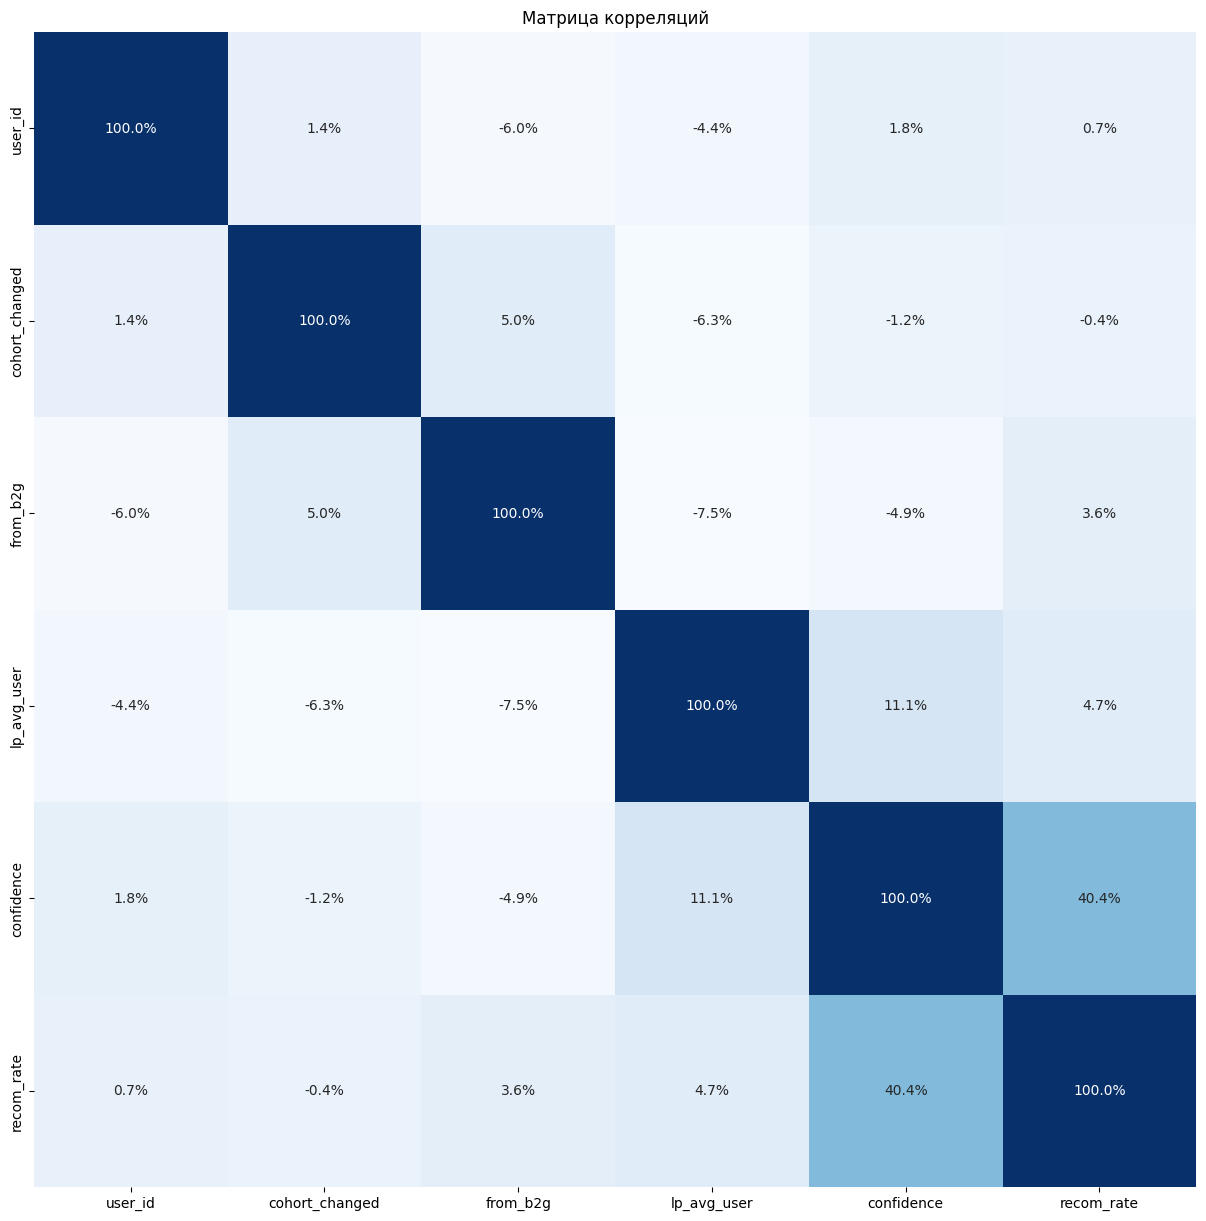

In [ ]:
cm = data[['user_id', 'cohort_changed', 'from_b2g', 'lp_avg_user', 'confidence', 'recom_rate']].corr()
plt.figure(figsize=(15,15))
#cmap=sns.light_palette("#5686E3", reverse=False, as_cmap=True)
sns.heatmap(cm, 
            annot=True,
            fmt='.1%', 
            cmap='Blues',
            cbar=False)
plt.title('Матрица корреляций') 
plt.show()

Предположительно есть корреляция между двумя параметрами, посмотрим ближе:

<Figure size 1200x800 with 0 Axes>

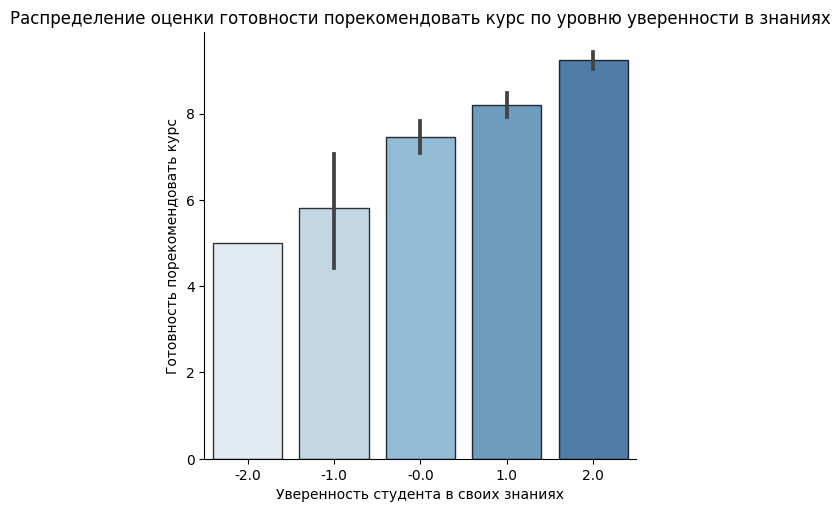

In [ ]:
plt.figure(figsize=(12,8))
sns.catplot(x='confidence', y='recom_rate', data=data[['confidence', 'recom_rate']].dropna(), kind='bar', ec='black', palette='Blues', alpha=.8)
plt.ylabel('Готовность порекомендовать курс')
plt.xlabel('Уверенность студента в своих знаниях')
plt.title('Распределение оценки готовности порекомендовать курс по уровню уверенности в знаниях')
plt.show()

Средняя оценка готовности порекомендовать курс увеличивается с ростом уверенности студента в своих знаниях.

### 5.2 Основные признаки датасета <a name="eda_2"></a>

Визуализируем основные признаки датасета:

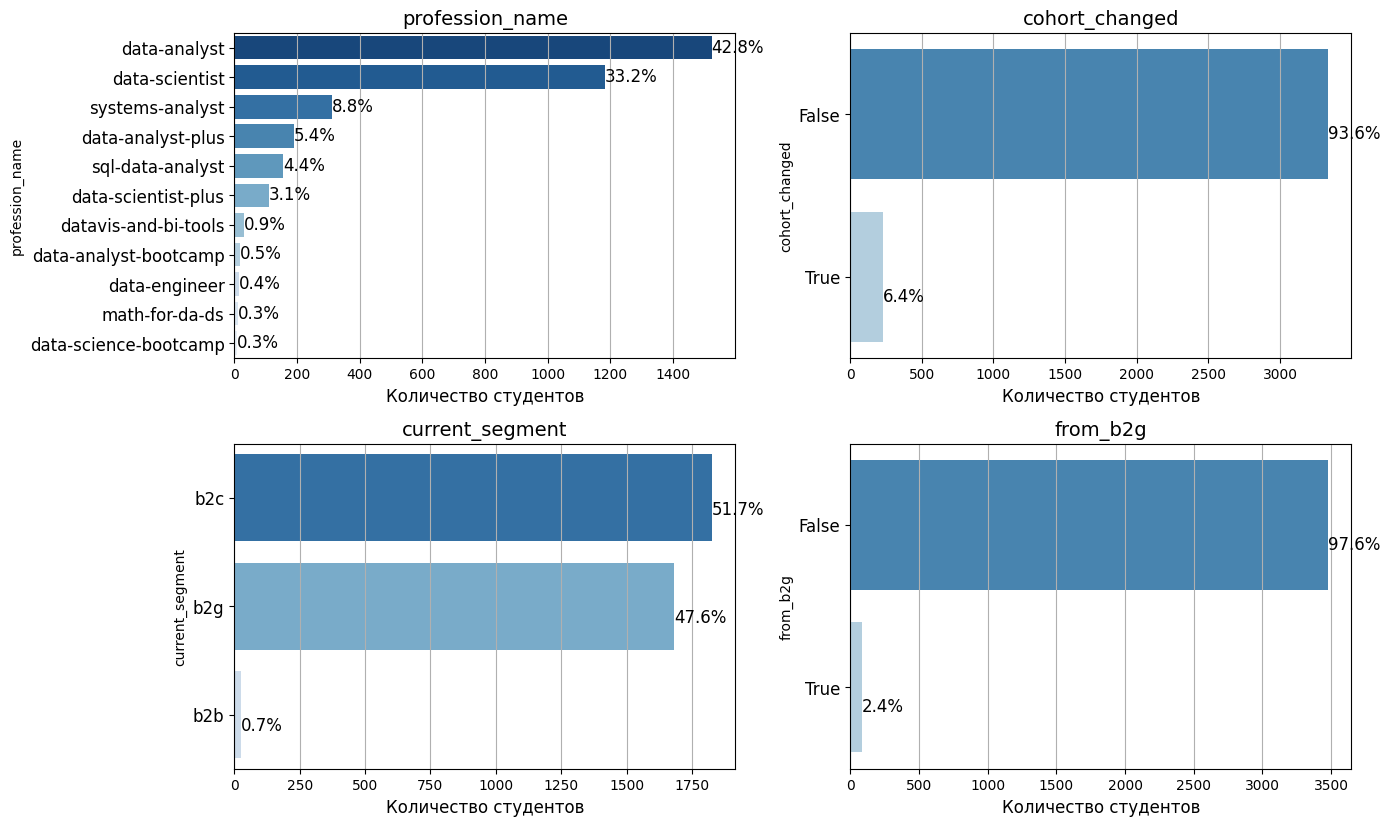

In [ ]:
columns = ['profession_name','cohort_changed', 'current_segment', 'from_b2g']
location = [321, 322, 323, 324, 325, 326]
xlabel = 'Подпись оси Х'

countplots(data, columns, location, 'Количество студентов')

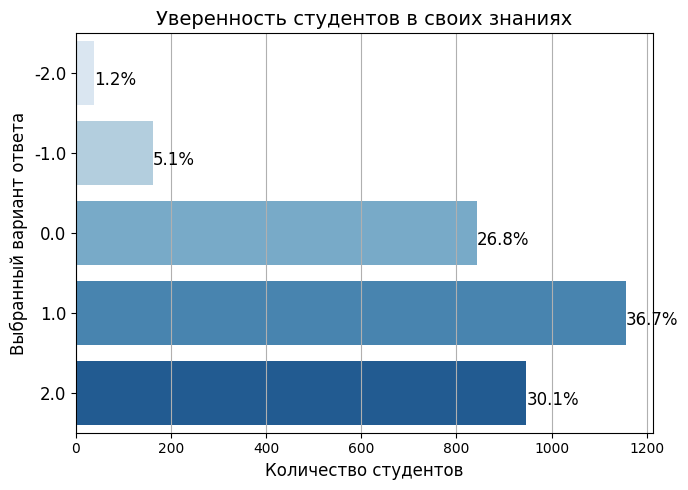

In [ ]:
plt.figure(figsize=(7, 5))
ax=sns.countplot(data = data, y='confidence', hue = None, palette=("Blues"))
plt.title('Уверенность студентов в своих знаниях', size=14) 
plt.yticks(size=12)
plt.xlabel('Количество студентов', size=12)
plt.ylabel('Выбранный вариант ответа', size=12)
plt.grid(True, axis='x')
add_perc_annot(ax, data['confidence'])
plt.tight_layout()
plt.show()

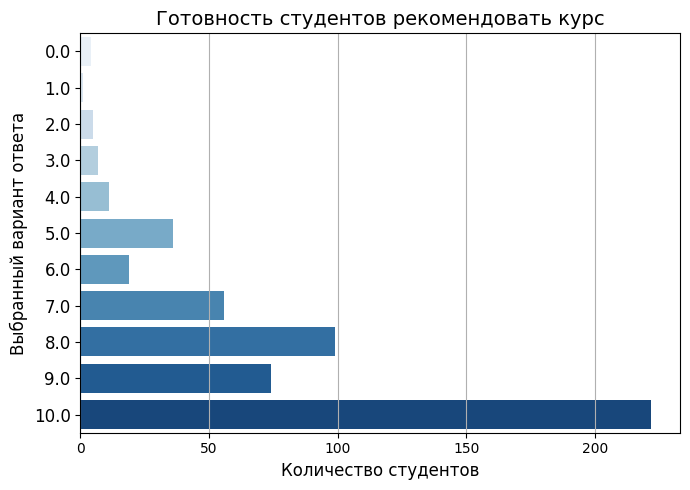

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(data = data, y='recom_rate', hue = None, palette=("Blues"))
plt.title('Готовность студентов рекомендовать курс', size=14) 
plt.yticks(size=12)
plt.xlabel('Количество студентов', size=12)
plt.ylabel('Выбранный вариант ответа', size=12)
plt.grid(True, axis='x')

plt.tight_layout()
plt.show()

Визуализируем некоторые признаки в другом виде:

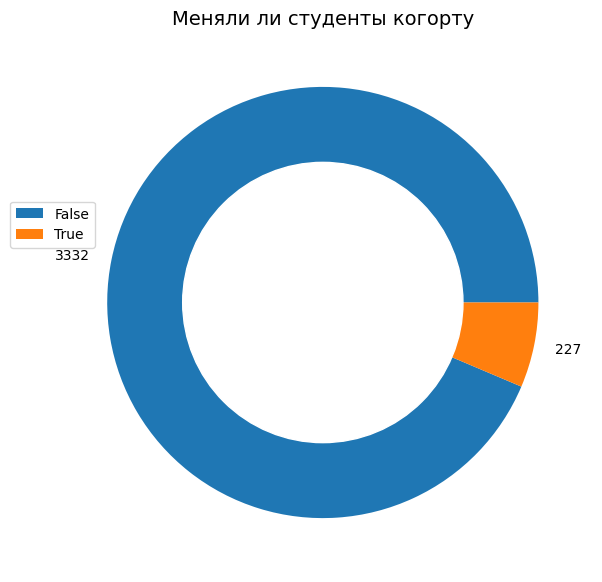

In [ ]:
circle_chart(data.groupby('cohort_changed', as_index=False).agg({'user_id':'count'}), 'Меняли ли студенты когорту')

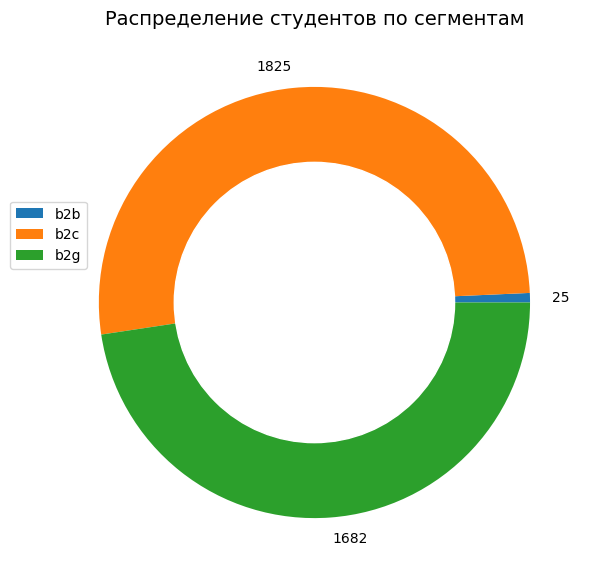

In [ ]:
circle_chart(data.groupby('current_segment', as_index=False).agg({'user_id':'count'}), 'Распределение студентов по сегментам')

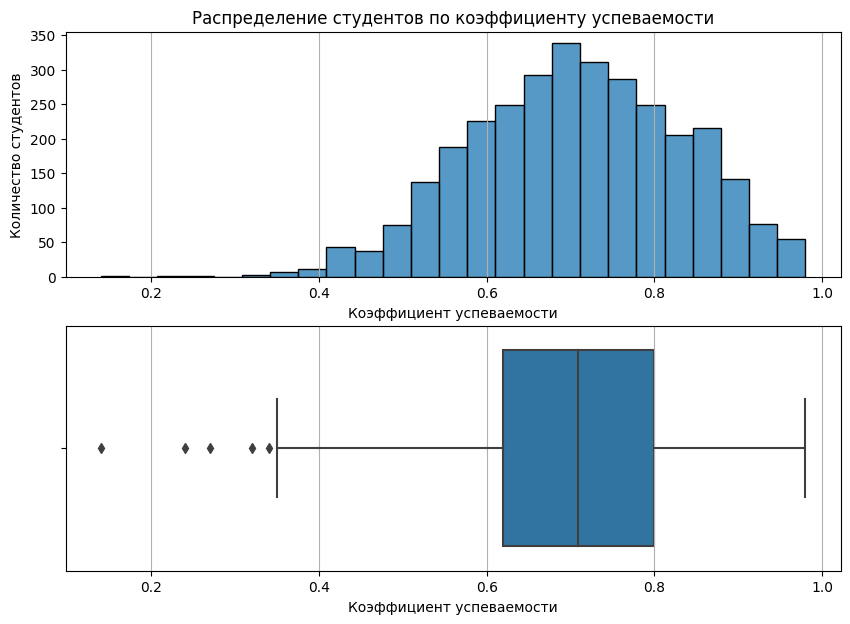

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
sns.histplot(data['lp_avg_user'], bins=25)
plt.title('Распределение студентов по коэффициенту успеваемости')
plt.xlabel('Коэффициент успеваемости')
plt.ylabel('Количество студентов')
plt.grid(True, axis='x')
plt.subplot(2,1,2)
sns.boxplot(x=data['lp_avg_user'])
plt.xlabel('Коэффициент успеваемости')
plt.grid(True, axis='x')
plt.show()

days_percentile = np.percentile(data['lp_avg_user'], [85, 90, 95])

Что можем сказать сразу:

* Большая часть студентов, ответивших на соответствующий вопрос, готовы рекомендовать курс.
* Самые объемные сегменты b2g и b2c. B2b практически не представлен, возможно  работодатель просит не включать «Трудоустройство» в курс своим работникам. 
* Больше всего студентов учатся на направлениях data analyst и data scientist.
* Большая часть студентов умеренно уверены в полученных ими знаниях, также четверть студентов не могут оценить свои знания.
* Чаще всего студенты доучиваются в тех когортах, в которых начали обучение.
* Cлучаи перехода из b2g в b2c ещё более редки.
* У половины студентов коэффициент успеваемости от 0.6 до 0.8. Есть отдельные выбросы по этому показателю в диапазоне до 0.4


### 5.3 Ответы студентов на вопросы: <a name="eda_3"></a>

Посмотрим, как студенты отвечали на вопросы.

При этом в вопросе про бэкграунд объединим варианты 'Нет опыта работы аналитиком и в IT.' и 'Нет опыта работы в IT и в направлении Анализа данных.'

In [ ]:
data.loc[data['q2_background'] == 'Нет опыта работы аналитиком и в IT.', 'q2_background'] = 'Нет опыта работы в IT и в направлении Анализа данных.'

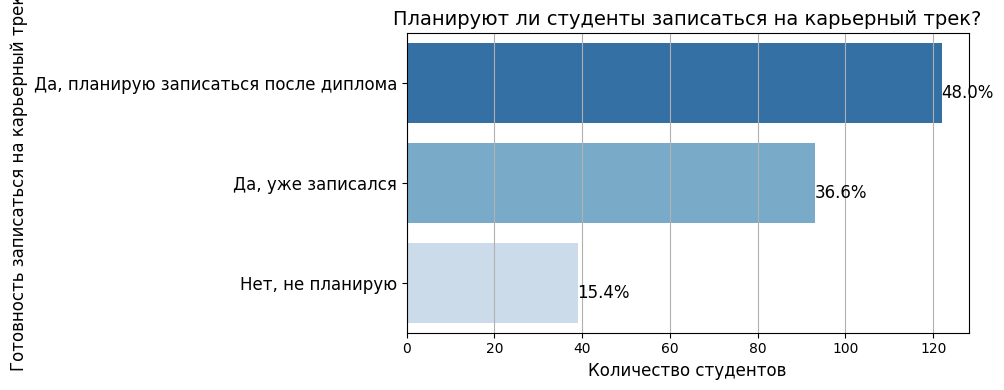

In [ ]:
large_to_small = data.groupby('q4_career_track').size().sort_values().index[::-1]
plt.figure(figsize=(10,4))
ax = sns.countplot(data = data, y='q4_career_track', hue = None, order=large_to_small, palette=("Blues_r"))
plt.title('from_b2g', size=14) 
plt.yticks(size=12)
plt.xlabel(xlabel, size=12)
add_perc_annot(ax, data['q4_career_track'])
plt.grid(True, axis='x')
plt.tight_layout()
plt.title('Планируют ли студенты записаться на карьерный трек?', size=14)
plt.xlabel('Количество студентов', size=12)
plt.ylabel('Готовность записаться на карьерный трек', size=12)
plt.show()

Посмотрим, зависят ли цели студентов от желания записаться на карьерный трек:

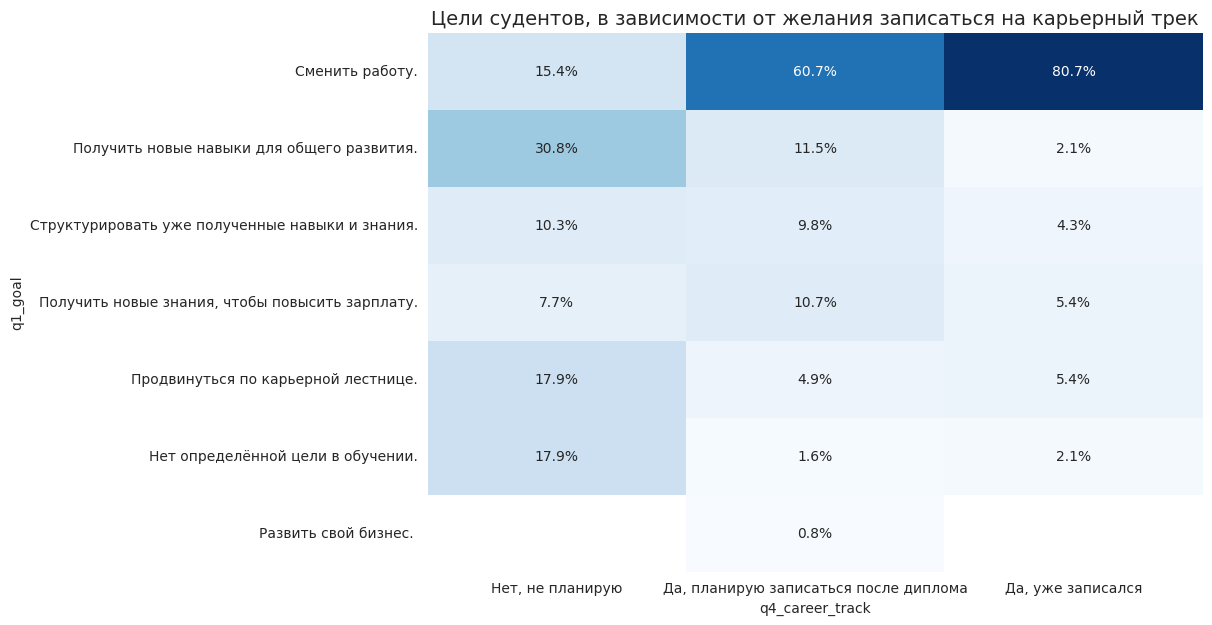

In [ ]:
career_track_goals = data.pivot_table(index='q4_career_track', columns='q1_goal', values='user_id', aggfunc='nunique')

for x in range(0,len(career_track_goals)):
    career_track_goals.iloc[x]=round(career_track_goals.iloc[x]/career_track_goals.iloc[x].sum(), 4)

plt.figure(figsize=(10,7))
sns.set_style('white')
#cmap=sns.light_palette("#5686E3", reverse=False, as_cmap=True)
sns.heatmap(sort_axis_by_median(career_track_goals).transpose(), cmap='Blues', annot=True, fmt='.1%', cbar=False)
plt.title('Цели судентов, в зависимости от желания записаться на карьерный трек', size=14)
plt.show()

Не планируют записываться на карьерный трек студенты, у который основная цель обучения - получить новые навыки для общего развития (31%), продвинуться по карьерной лестнице(18%) или у кого нет определённой цели в обучении (18%). Тем не менее, более 15% таких студентов преследуют цель сменить работу. Попробуем понять, нашли ли уже такие студенты работу:

In [ ]:
data.query('q4_career_track == "Нет, не планирую"').groupby('q3_job_status').agg({'user_id':'nunique'})

,user_id
q3_job_status,


Студенты, которые ответили на вопрос о желании записаться на карьерный трек отрицательно, не отвечали на вопрос о том, устроились ли они уже на работу во время обучения. Возможно, стоит собрать больше данных о таких пользователях, например задавать им в опроснике дополнительный вопос о причинах отсутствия желания записаться на карьерный трек.

Продолжим обзор ответов на вопросы.

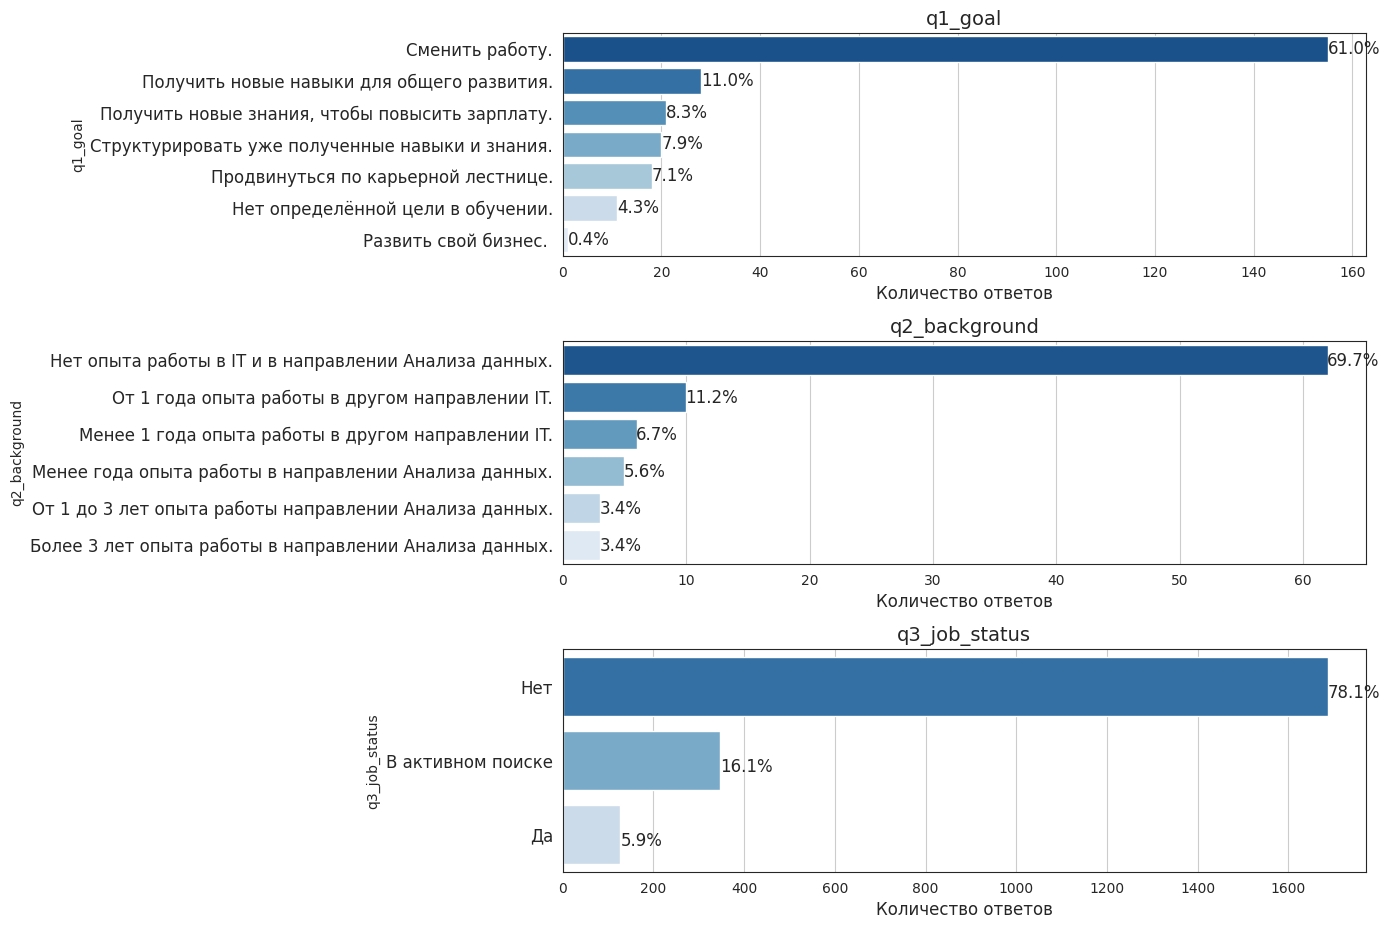

In [ ]:
columns = ['q1_goal', 'q2_background', 'q3_job_status']
location = [411, 412, 413]
countplots(data, columns, location, 'Количество ответов')

Визуализируем некоторые графики в другом виде:

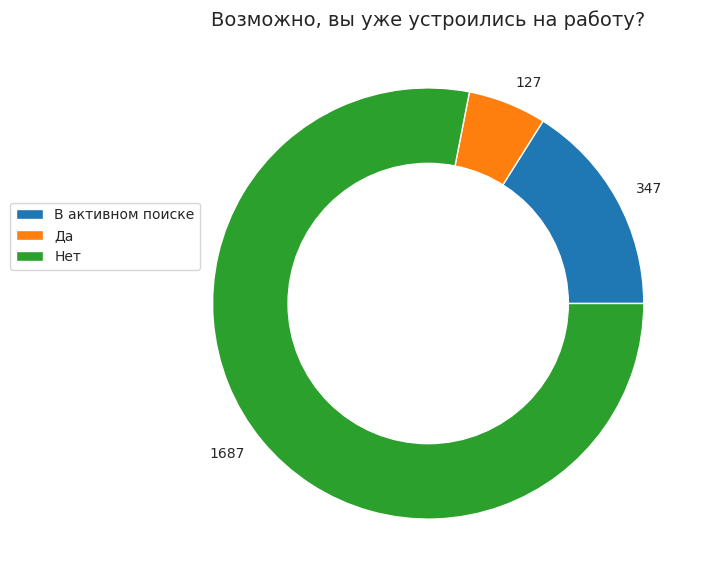

In [ ]:
circle_chart(data.groupby('q3_job_status', as_index=False).agg({'user_id':'count'}), 'Возможно, вы уже устроились на работу?')

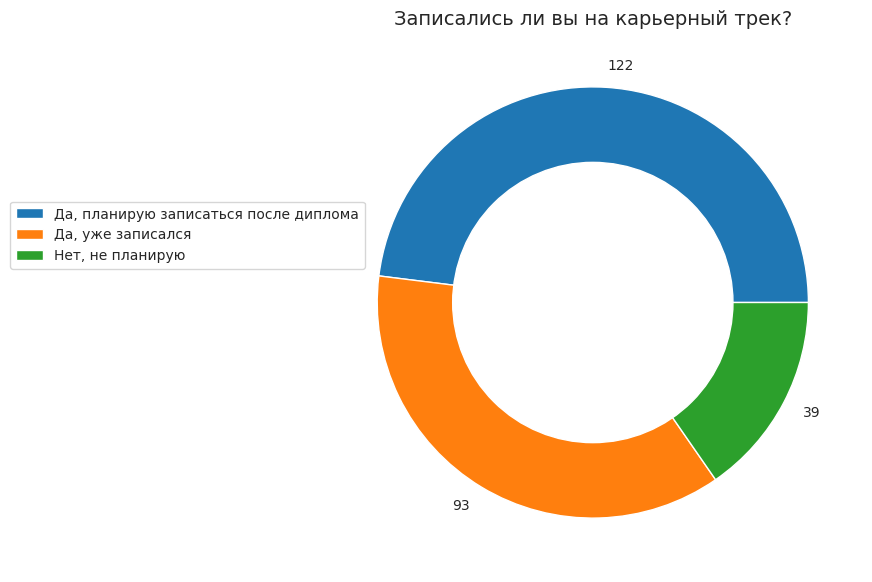

In [ ]:
circle_chart(data.groupby('q4_career_track', as_index=False).agg({'user_id':'count'}), 'Записались ли вы на карьерный трек?')

Выводы из ответов на данные вопросы:
1. Большая часть студентов записывалась на курс, чтобы сменить работу. И нет ни одного студента, который бы записывался на курс, чтобы развить свой бизнес.
2. Большая часть студентов записывается на курсы, не имея опыта работы в IT или с минимальным опытом в другом направлении IT.
3. Большая часть студентов на курсе "Трудоустройство" ещё не устроились на работу.
4. На карьерный трек большая часть студентов курса или уже записались, или планируют записаться по окончании диплома (последний вариант популярнее).

### 5.4 Запросы студентов <a name="eda_4"></a>

Отдельно рассмотрим, как отвечали студенты на вопрос о том, что они хотят получить от курса. Здесь студенты могли выбрать несколько вариантов ответа.

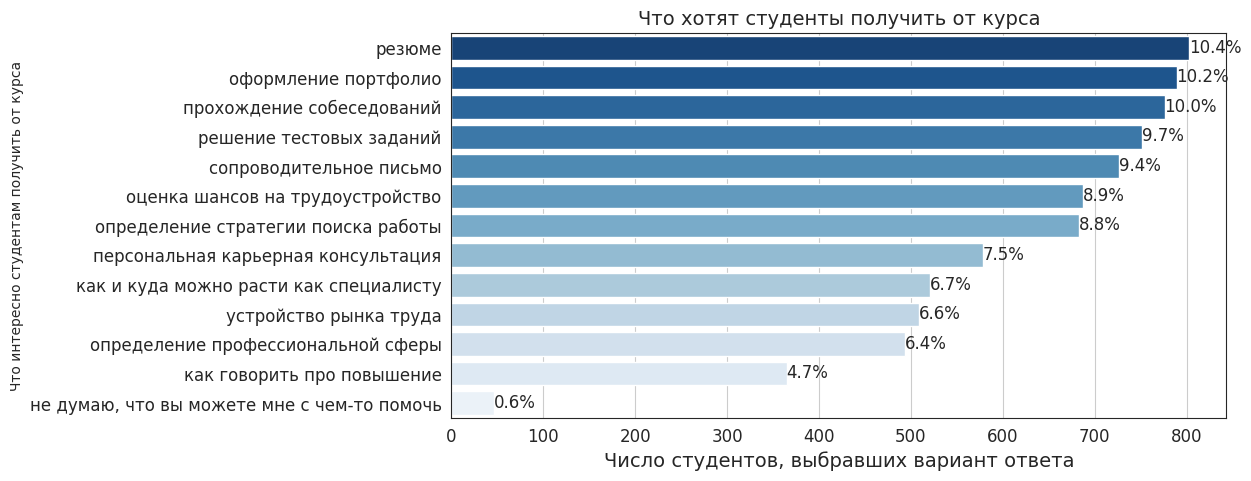

In [ ]:
user_interests=data.groupby('user_id').agg({'как говорить про повышение':'sum',
                                      'как и куда можно расти как специалисту':'sum',
                                      'не думаю, что вы можете мне с чем-то помочь':'sum',
                                      'определение профессиональной сферы':'sum',
                                                       'определение стратегии поиска работы':'sum',
                                                       'оформление портфолио':'sum',
                                                       'оценка шансов на трудоустройство':'sum',
                                                       'персональная карьерная консультация':'sum',
                                                       'прохождение собеседований':'sum',
                                                       'резюме':'sum',
                                                       'решение тестовых заданий':'sum',
                                                       'сопроводительное письмо':'sum',
                                                       'устройство рынка труда':'sum'})\
        .sum().transpose().sort_values(ascending=False).reset_index()

user_interests.columns=['Что интересно студентам получить от курса', 'Количество студентов']

plt.figure(figsize=(10,5))
ax=sns.barplot(y=user_interests['Что интересно студентам получить от курса'], x=user_interests['Количество студентов'], orient='h', palette=("Blues_r"))
plt.title('Что хотят студенты получить от курса', size=14)
plt.xlabel('Число студентов, выбравших вариант ответа', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True, axis='x')
add_perc_bar(ax, user_interests['Количество студентов'])
plt.show()

Видим, что в целом студентов больше всего интересуют практические навыки прохождения этапов трудоустройства, такие как:
- составлению резюме
- портфолио
- прохождению собеседований
- решение тестовых заданий 
- написание сопроводительных писем

Меньше интересуют стратегические вопросы:
- оценка шансов на трудоустройство
- определение стратегии поиска работы
- персональная карьерная консультация

Меньше всего студентов интересуют более общие вопросы:
- как и куда расти как специалисту
- устройство рынка труда
- определение профессиональной сферы
- как говорить про повышение

Радует, что студенты настроены позитивно: вариант "не думаю, что вы можете мне с чем-то помочь" выбран наименьшим числом студентов.

Определим число ответов на этот вопрос по профессиям.

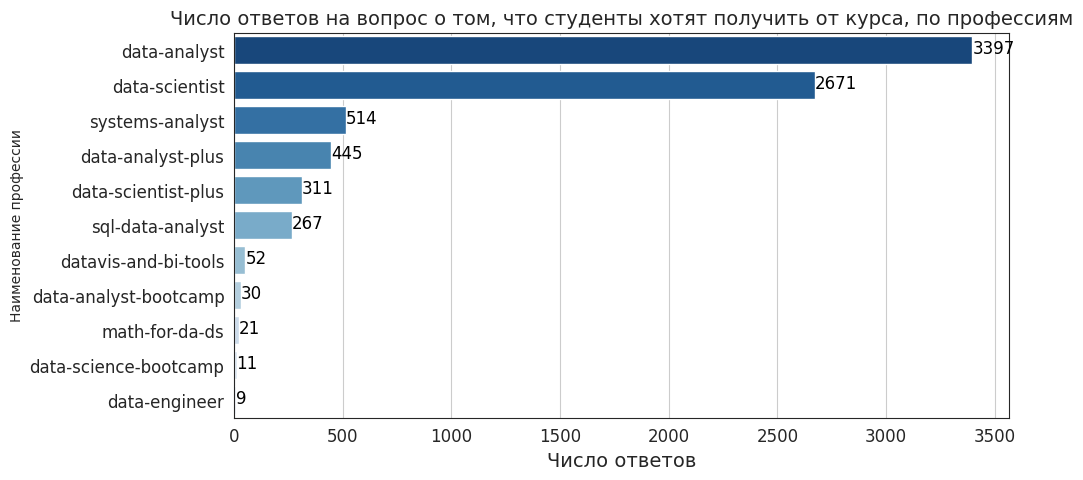

In [ ]:
interests_prof = data.groupby('profession_name').agg({'как говорить про повышение':'sum',
                                      'как и куда можно расти как специалисту':'sum',
                                      'не думаю, что вы можете мне с чем-то помочь':'sum',
                                      'определение профессиональной сферы':'sum',
                                                       'определение стратегии поиска работы':'sum',
                                                       'оформление портфолио':'sum',
                                                       'оценка шансов на трудоустройство':'sum',
                                                       'персональная карьерная консультация':'sum',
                                                       'прохождение собеседований':'sum',
                                                       'резюме':'sum',
                                                       'решение тестовых заданий':'sum',
                                                       'сопроводительное письмо':'sum',
                                                       'устройство рынка труда':'sum'}).transpose().sum().sort_values(ascending=False).reset_index()
interests_prof.columns=['Наименование профессии', 'count']

plt.figure(figsize=(10,5))
ax=sns.barplot(y=interests_prof['Наименование профессии'], x=interests_prof['count'], orient='h', palette=("Blues_r"))
plt.title('Число ответов на вопрос о том, что студенты хотят получить от курса, по профессиям', size=14)
plt.xlabel('Число ответов', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True, axis='x')
for p in ax.patches:
    percentage = '{:.0f}'.format(p.get_width())
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() - 0.3
    ax.annotate(percentage, (x, y), color='black', size = 12)
plt.show()

Ответ на этот вопрос будем считать релевантным для профессий, где число ответов не менее 100.
Построим график ответов на этот вопрос:

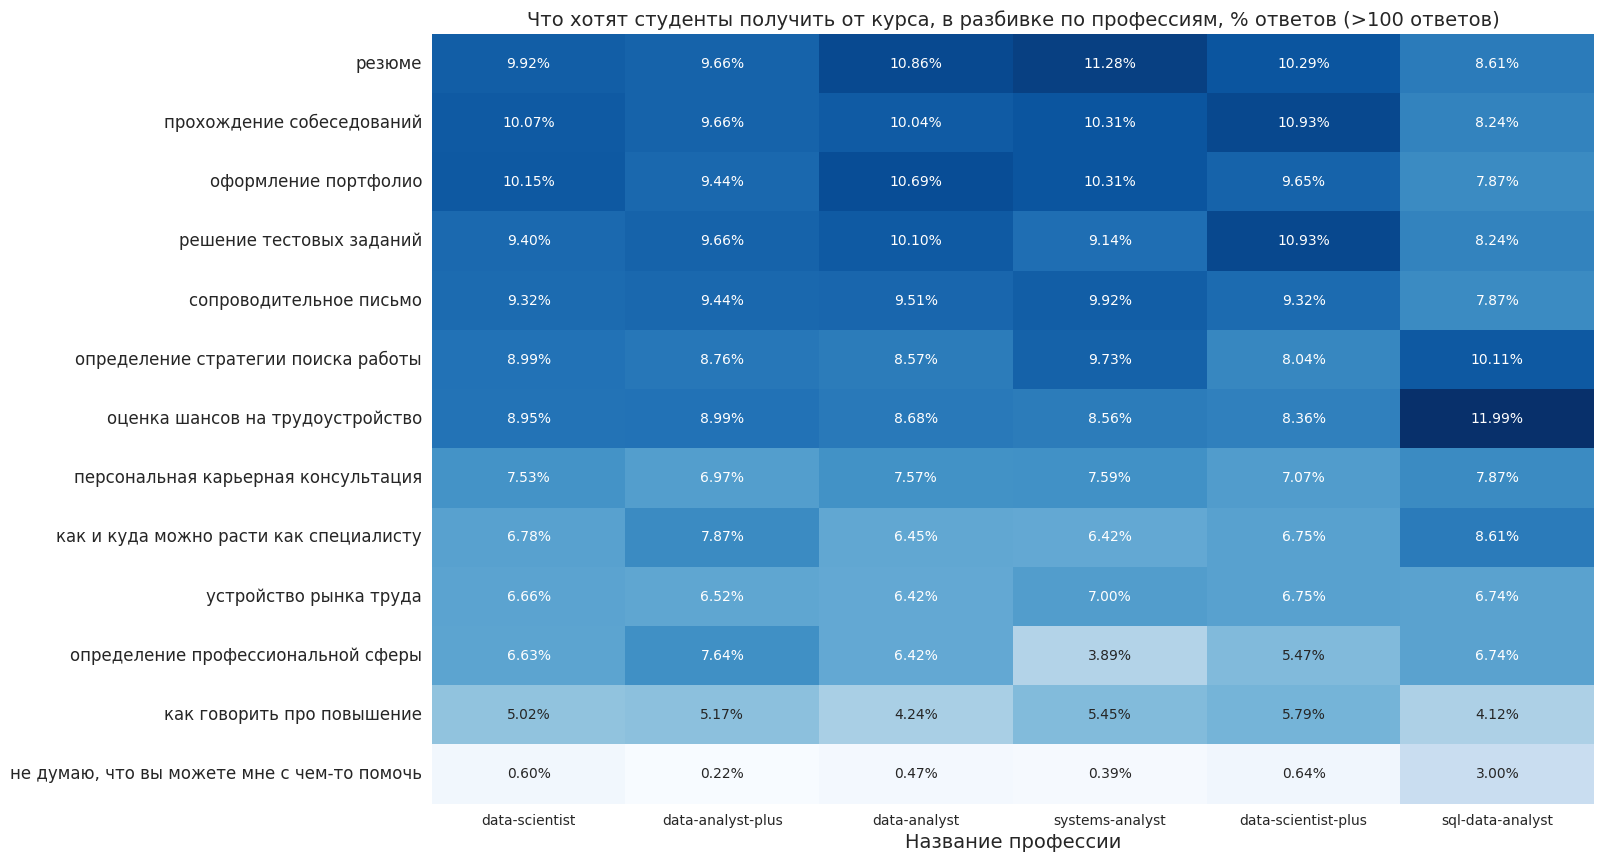

In [ ]:
professions_int = interests_prof.query('count>=100')['Наименование профессии']
interests_prof = data.query('profession_name.isin(@professions_int)').groupby('profession_name').agg({'как говорить про повышение':'sum',
                                      'как и куда можно расти как специалисту':'sum',
                                      'не думаю, что вы можете мне с чем-то помочь':'sum',
                                      'определение профессиональной сферы':'sum',
                                                       'определение стратегии поиска работы':'sum',
                                                       'оформление портфолио':'sum',
                                                       'оценка шансов на трудоустройство':'sum',
                                                       'персональная карьерная консультация':'sum',
                                                       'прохождение собеседований':'sum',
                                                       'резюме':'sum',
                                                       'решение тестовых заданий':'sum',
                                                       'сопроводительное письмо':'sum',
                                                       'устройство рынка труда':'sum'})

for x in range(0,len(interests_prof)):
    interests_prof.iloc[x]=round(interests_prof.iloc[x]/interests_prof.iloc[x].sum(), 4)

plt.figure(figsize=(15,10))
#cmap=sns.light_palette("#5686E3", reverse=False, as_cmap=True)
sns.heatmap(sort_axis_by_median(interests_prof).transpose(), annot=True, cmap='Blues', fmt=".2%", cbar=False)
plt.title('Что хотят студенты получить от курса, в разбивке по профессиям, % ответов (>100 ответов)', size=14)
plt.xticks(size=10)
plt.yticks(size=12)
plt.xlabel('Название профессии', size=14)
plt.show()

Ответы на вопрос распределены по всем профессиям похожим образом, кроме профессии `sql-data-analyst`: студенты этого курса больше заинтересованы в "стратегических" вопросах: "оценка шансов на трудоустройство" и "опредление стратегии поиска работы". Процент ответа "не думаю, что вы можете мне с чем-то помочь", тоже самый высокий. Видимо, выпускники этого курса чувствуют себя менее уверенно в вопросах трудоустройства.

### 5.5 Текстовые ответы <a name="eda_5"></a>

Также отдельно рассмотрим текстовые комментарии. Определим, насколько подробные студенты готовы оставлять комментарии.

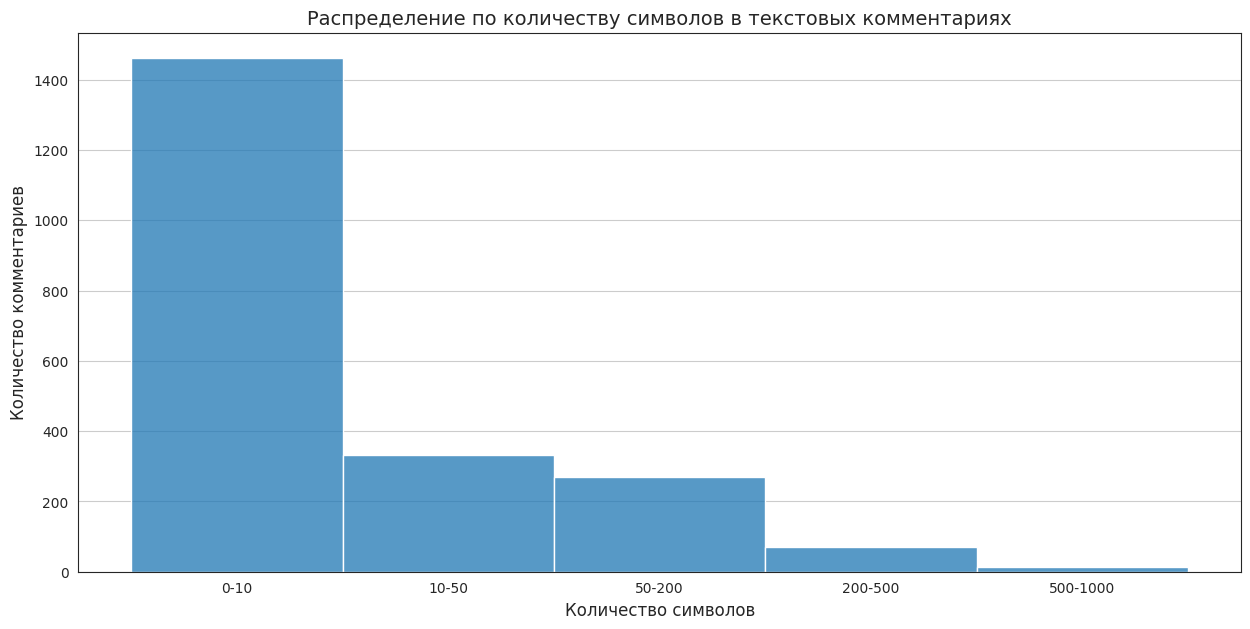

In [ ]:
text_comments=data.groupby('user_id').agg({'q5_text_comment':'last'}).query('q5_text_comment.notna()')
text_comments['text_len']=text_comments['q5_text_comment'].str.len()
cut_labels = ['0-10', '10-50', '50-200', '200-500', '500-1000']
cut_bins = [0, 10, 50, 200, 500, 1000]
text_comments['len_segm'] = pd.cut(text_comments['text_len'],
                       bins=cut_bins,
                       labels=cut_labels)

plt.figure(figsize=(15,7))
ax=sns.histplot(data=text_comments, x='len_segm')
sns.set_style("darkgrid")
plt.title('Распределение по количеству символов в текстовых комментариях', size=14)
plt.xlabel('Количество символов',size=12)
plt.ylabel('Количество комментариев',size=12)
plt.grid(True, axis='y')
plt.show()

Большая часть комментариев - до 200 символов. Посмотрим на наиболее часто встречающиеся в них слова, используя wordcloud:

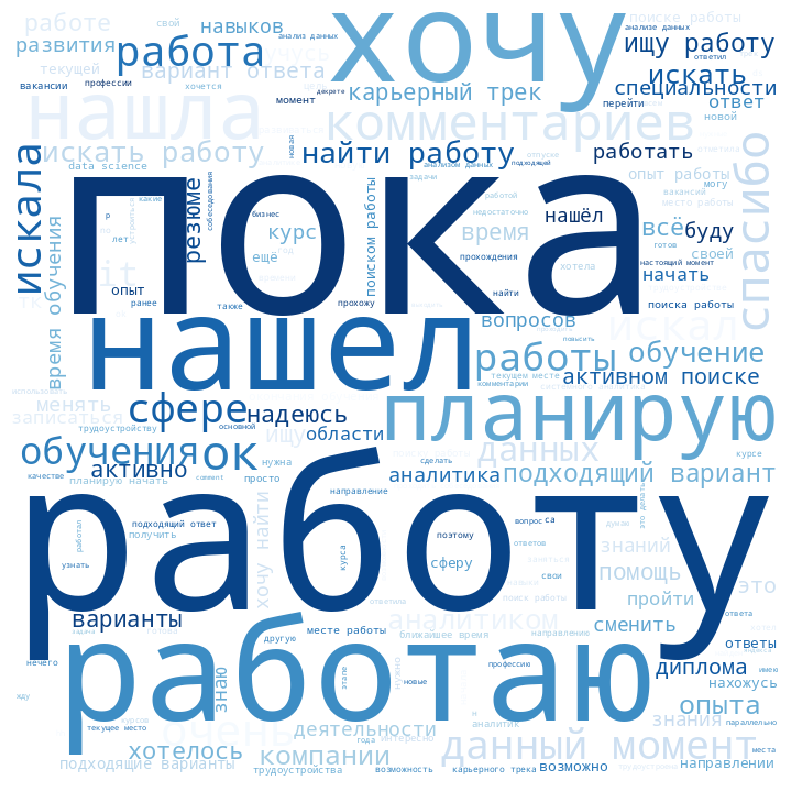

In [ ]:
text=" ".join(list(text_comments.query('text_len > 0 and text_len <= 200 ')['q5_text_comment']))
text=clean_text(text)
link_font='https://disk.yandex.ru/d/F99dV4lzh8Yzdw'
text_cloud(text)

Наиболее часто в комментариях может содержаться информация о том, нашёл студент работу или ещё ищет. Поскольку такой вопрос уже содержался в опроснике, опираться в анализе на эти текстовые комментарии не будем. Но, возможно, в более длинных комментариях содержится более детальная информация о тех трудностях, с которыми сталкиваются студенты.

Посмотрим на комментарии от 200 символов, отберём 5 случайных:

In [ ]:
list(text_comments.query('text_len > 200')['q5_text_comment'].sample(5))

['У меня большой опыт в банковской сфере - около 17 лет в кредитовании юридических и физических лиц. Последние 10 лет занимала исключительного руководящие позиции. В работе приходилось сталкиваться с big data, но не было навыков использования нужных инструментов, поэтому обходились только экселем))) Отчасти это и сподвигло пойти учиться, плюс давно хотелось попробовать себя в IT/ \nХотелось бы найти работу на стыке  уже имеющегося огромного опыта и новых знаний, например,  в финтехе.',
 'Смог устроиться на парт-тайм в агентство стажером в начале обучения, дорос там до джуна, но основная работа по-прежнему не совсем и не только про анализ данных - хочу перейти в другую крупную IT-компанию на фул-тайм на upper-junior/middle-позицию',
 'На данный момент нахожусь в отпуске по уходу за ребенком. Смогу выйти на работу только в сентябре (когда малыш пойдет в детский сад), поэтому карьерный трек и активный поиск работы будет после диплома, ближе к лету.',
 'Я пока сильно не уверенна в своих зн

 В основном люди пишут о себе и о своём опыте, расширяя ответы, данные ранее в опроснике. Возможно, стоит провести отдельное исследование многосимвольных комментариев, которое позволит лучше понять боли пользователей, скорректировать работу коучей, дополнить опросник.

### 5.6 Особенности сегментов <a name="eda_6"></a>

Посмотрим, как пользователи B2B, B2G и B2C распределены по профессиям.

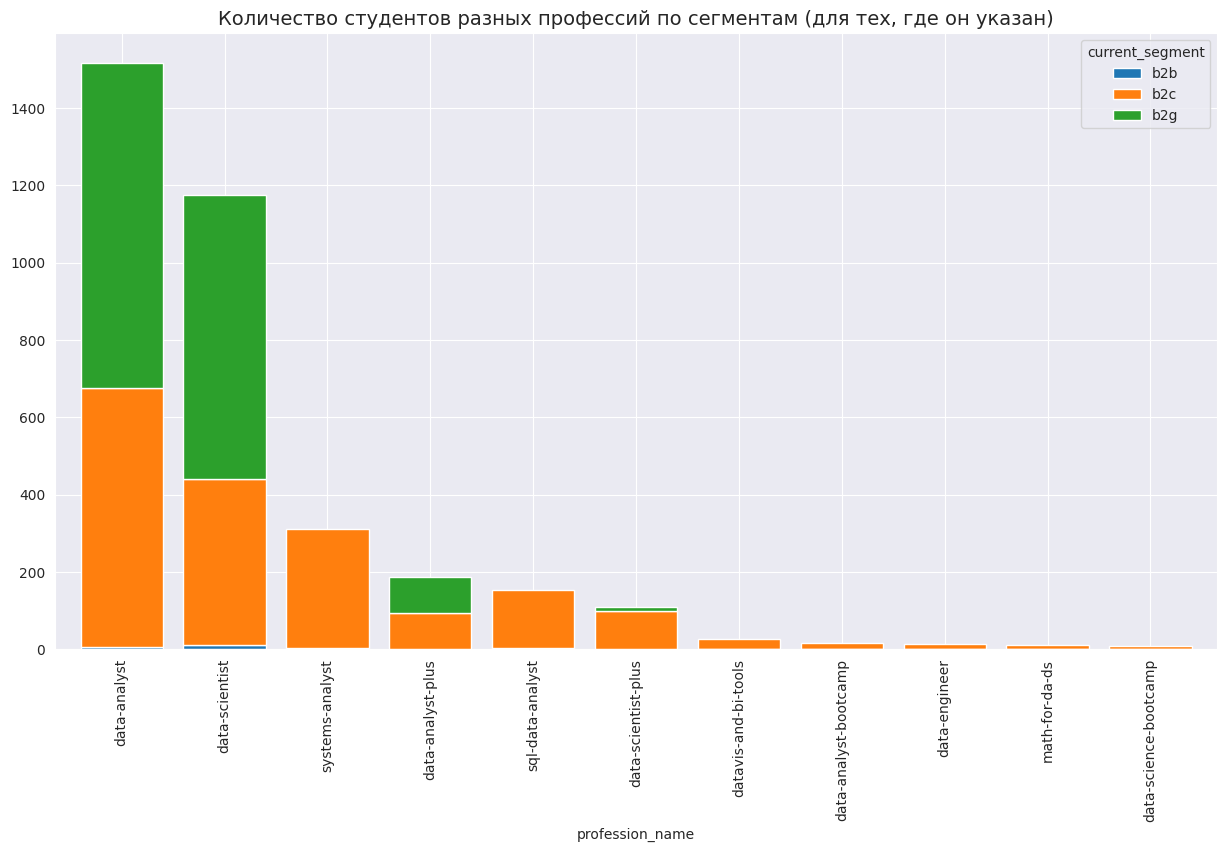

In [ ]:
segment_prof_users=(
    (data.groupby(['current_segment', 'profession_name'], as_index=False)
     .agg({'user_id':'count'})
     .rename(columns={'user_id':'count_users'}))
    .pivot_table(index='profession_name', columns='current_segment', values='count_users', aggfunc='sum')
)
segment_prof_users['total']=segment_prof_users.sum(axis=1)
segment_prof_users=segment_prof_users.sort_values(by='total', ascending=False).drop(columns='total')

ax=segment_prof_users.plot(kind='bar', stacked=True, figsize=(15,8), width=0.8)
plt.title('Количество студентов разных профессий по сегментам (для тех, где он указан)', size=14)
plt.show()

Большинство пользователей сегмента B2G записывались в профессии data-analyst и data-scientist, небольшая доля - в data-analyst-plus и data-scientist-plus. Видимо, остальные курсы не вошли в программу гос.софинансирования. Сегмент b2b представлен крайне слабо, они присутствуют только в профессиях data-analyst и data-scientist. Не будем, впрочем, забывать, что у нас результаты опроса студентов "Трудоустройства", а поскольку b2b студентам не требуется трудоустройство, работодатель иожет иметь возможность блокировать прохождение этого курса своим сотрудникам.

Посмотрим на распределение успеваемости по сегментам:

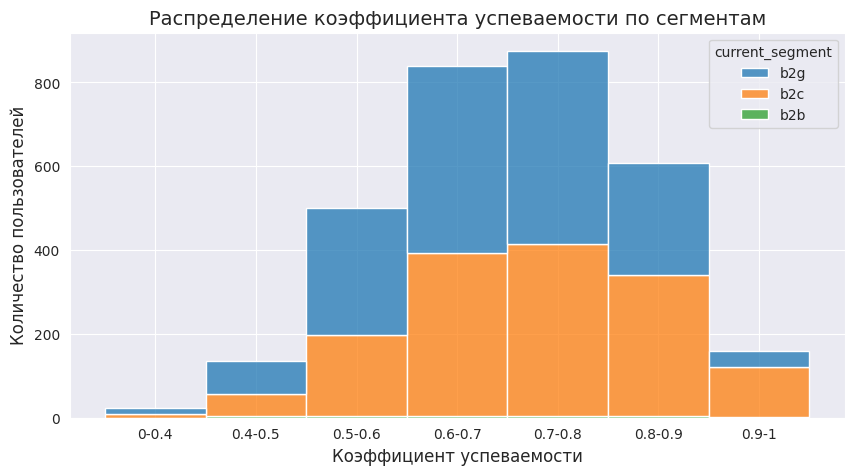

In [ ]:
segment_lp=data.groupby('user_id').agg({'lp_avg_user':'mean', 'current_segment':'first'})
cut_labels = ['0-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']
cut_bins = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
segment_lp['lp_avg'] = pd.cut(segment_lp['lp_avg_user'],
                       bins=cut_bins,
                       labels=cut_labels)

plt.figure(figsize=(10,5))
sns.histplot(data=segment_lp, x='lp_avg', hue='current_segment', multiple='stack')
sns.set_style("darkgrid")
plt.title('Распределение коэффициента успеваемости по сегментам', size=14)
plt.xlabel('Коэффициент успеваемости',size=12)
plt.ylabel('Количество пользователей',size=12)
plt.grid(True)
plt.show()

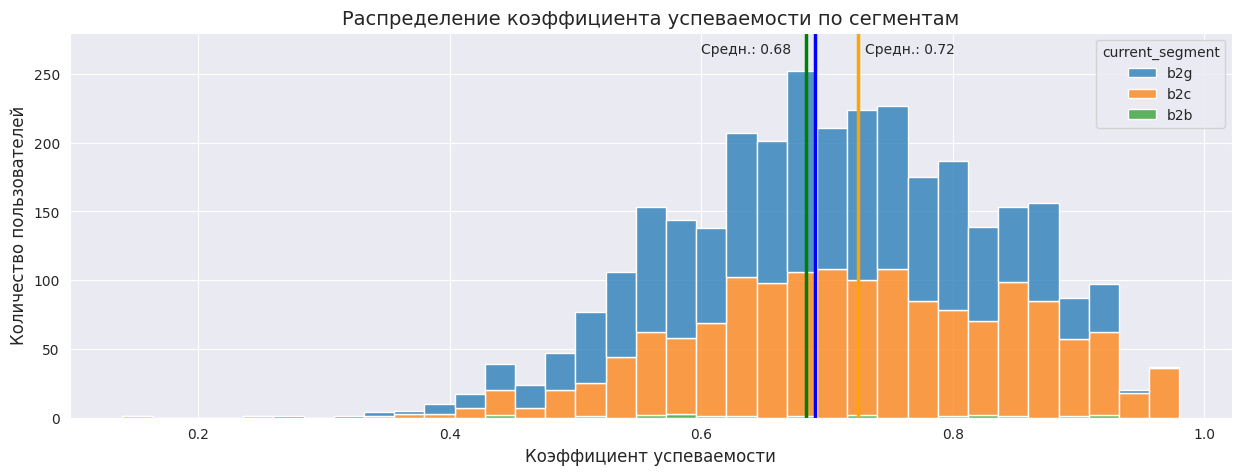

In [ ]:
segment_lp_avg=data.groupby('current_segment').agg({'lp_avg_user':'mean'})
                            
plt.figure(figsize=(15,5))
sns.histplot(data.groupby('user_id').agg({'lp_avg_user':'mean', 'current_segment':'first'}), x='lp_avg_user', hue='current_segment', multiple='stack')
plt.title('Распределение коэффициента успеваемости по сегментам', size=14)
plt.xlabel('Коэффициент успеваемости',size=12)
plt.ylabel('Количество пользователей',size=12)
plt.axvline(segment_lp_avg.loc['b2c','lp_avg_user'], c='orange', ls='-', lw=2.5)
plt.axvline(segment_lp_avg.loc['b2b','lp_avg_user'], c='g', ls='-', lw=2.5)
plt.axvline(segment_lp_avg.loc['b2g','lp_avg_user'], c='b', ls='-', lw=2.5)
plt.text(round(segment_lp_avg.loc["b2b","lp_avg_user"], 2)-0.08, 265, 
         f'Средн.: {round(segment_lp_avg.loc["b2b","lp_avg_user"], 2)}')
plt.text(round(segment_lp_avg.loc["b2c","lp_avg_user"], 2)+0.01, 265, 
         f'Средн.: {round(segment_lp_avg.loc["b2c","lp_avg_user"], 2)}')
plt.grid(True, axis='y')
plt.ylim(0,280)
plt.show()

Средняя успеваемость студентов сегмента b2g и b2b немного ниже успеваемости сегмента b2c, что может объясняться дополнительной мотивацией за счёт оплаченного лично курса. 

Посмотрим, сколько студентов перешли из b2g в b2c.

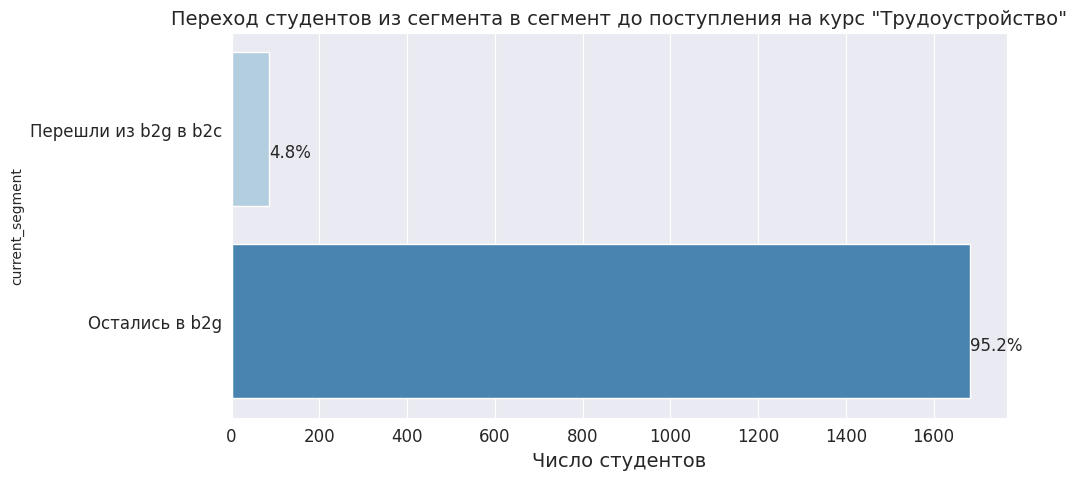

In [ ]:
segments_ch = data.query('current_segment == "b2g" or from_b2g == True').groupby('current_segment', as_index=False).agg({'user_id':'count'})
segments_ch['current_segment']=['Перешли из b2g в b2c', 'Остались в b2g']
plt.figure(figsize=(10,5))
ax=sns.barplot(y=segments_ch['current_segment'], x=segments_ch['user_id'], orient='h', palette=("Blues"))
plt.title('Переход студентов из сегмента в сегмент до поступления на курс "Трудоустройство"', size=14)
plt.xlabel('Число студентов', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True, axis='x')
add_perc_bar(ax, segments_ch['user_id'])
plt.show()

Большая часть студентов (95.2%) остались учиться до поступления на курс "Трудоустройство" в b2g,  небольшая часть (4.8%) перешли в b2c. Такой переход предположительно связан с невыполненим студентами условий государственой программы, в связи с чем они были вынуждены опатить курс самостоятельно и подолжать его уже в сегменте b2c. Таких студентов немного. Посмотрим, в каких они профессиях:

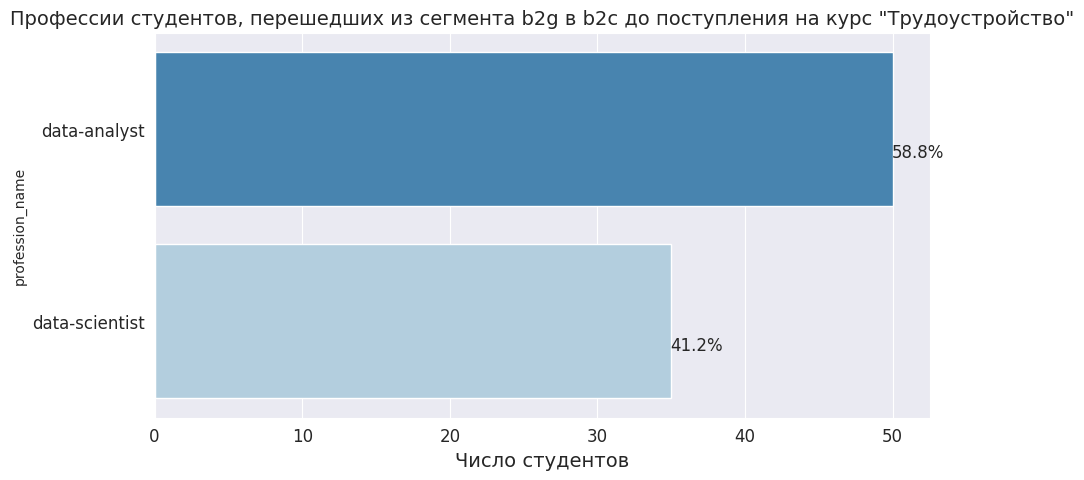

In [ ]:
segments_ch_prof=data.query('from_b2g == True').groupby('profession_name', as_index=False).agg({'user_id':'count'})

plt.figure(figsize=(10,5))
ax=sns.barplot(y=segments_ch_prof['profession_name'], x=segments_ch_prof['user_id'], orient='h', palette=("Blues_r"))
plt.title('Профессии студентов, перешедших из сегмента b2g в b2с до поступления на курс "Трудоустройство"', size=14)
plt.xlabel('Число студентов', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True, axis='x')
add_perc_bar(ax, segments_ch_prof['user_id'])
plt.show()

Большая часть студентов, поменявших сегмент, участся профессии `data-analyst`, немногим меньше - `data-scientist`.

### 5.7 Показатели в разрезе профессий <a name="eda_7"></a>

Рассмотрим некоторые показатели в разрезе профессий.

Начнём с вопроса, удалось ли студентам найти работу во время обучения.

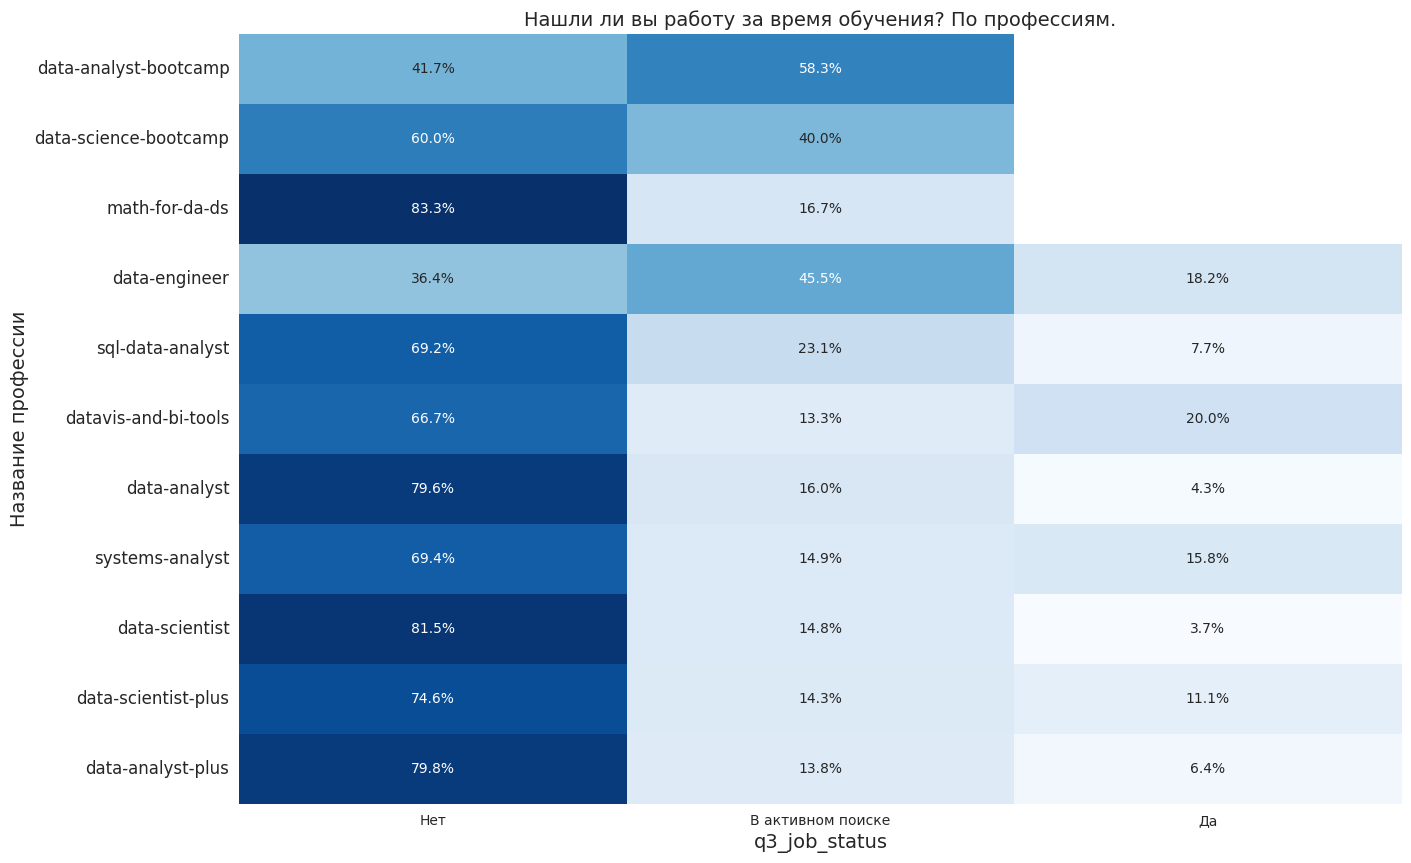

In [ ]:
heatmap_prof(data, 'q3_job_status', 'Нашли ли вы работу за время обучения? По профессиям.')

Выведем ту же информацию в другом виде.

<Figure size 1000x500 with 0 Axes>

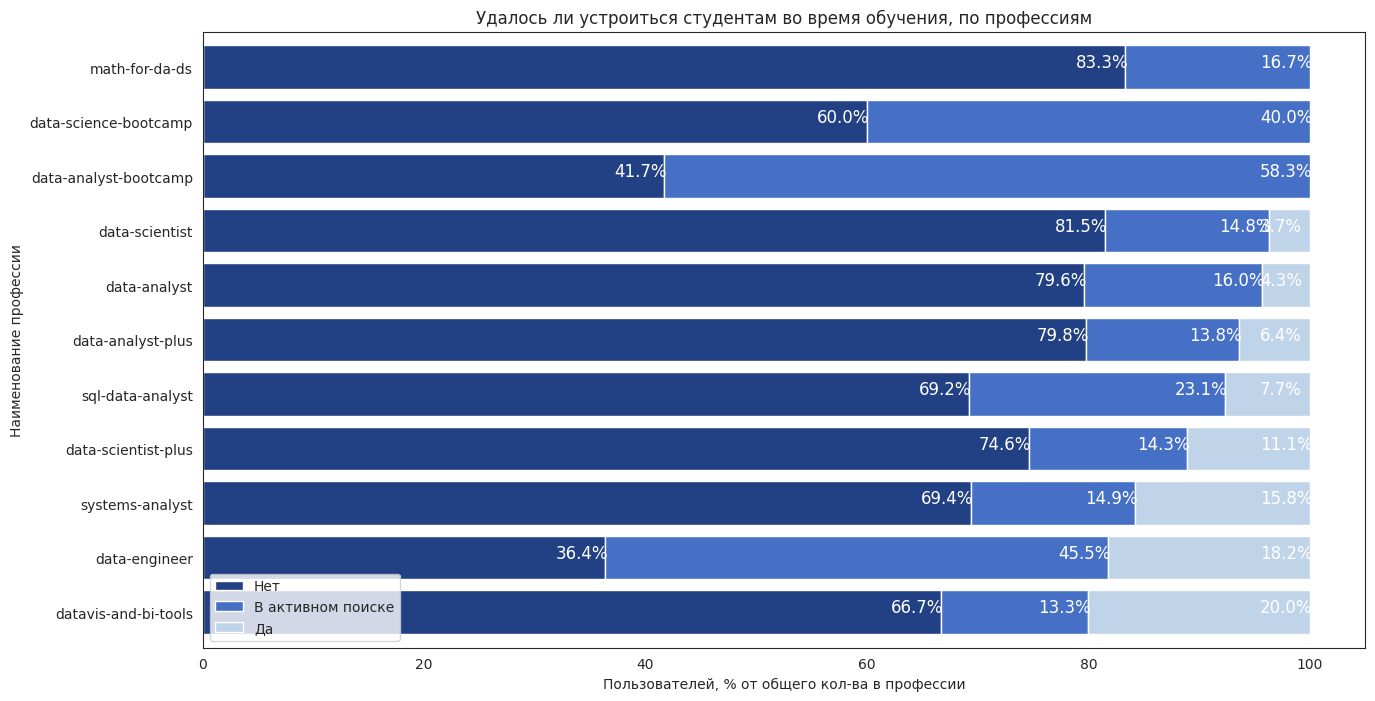

In [ ]:
prof_job=(data.pivot_table(index='profession_name', columns='q3_job_status', values='user_id', aggfunc='nunique')
          .reindex(columns=['Нет', 'В активном поиске', 'Да'])
)
for x in range(0,len(prof_job)):
  prof_job.iloc[x]=round(prof_job.iloc[x]*100/prof_job.iloc[x].sum(), 2)

prof_job = prof_job.sort_values(by='Да', ascending=False)

my_colors = ['#224084','#4670C5', '#C0D4E9']
plt.figure(figsize=(10,5))
ax=prof_job.plot(kind='barh', stacked=True, figsize=(15,8), width=0.8, color=my_colors)

for p in ax.patches:
  percentage = '{:.1f}%'.format(p.get_width())
  x = p.get_x() + p.get_width() - 4.5
  y = p.get_y() + p.get_height() - 0.4
  ax.annotate(percentage, (x, y), color='white', size = 12)
plt.title('Удалось ли устроиться студентам во время обучения, по профессиям')
plt.xlabel('Пользователей, % от общего кол-ва в профессии')
plt.ylabel('Наименование профессии')
plt.legend(loc='lower left')
plt.show()

Трудоустроенных за время обучения больше всего на курсах **systems-analyst**, **datavis-and-bi-tools**, **data-engineer**, но не более 20%.

Самые активные - студенты буткемпов и курса **data-engineer**

Больше всего не трудоустроенных и при этом не находящихся в активном поиске - **math-for-da-ds**, **data-scietist**, **data-analyst** и **data-analyst-plus**

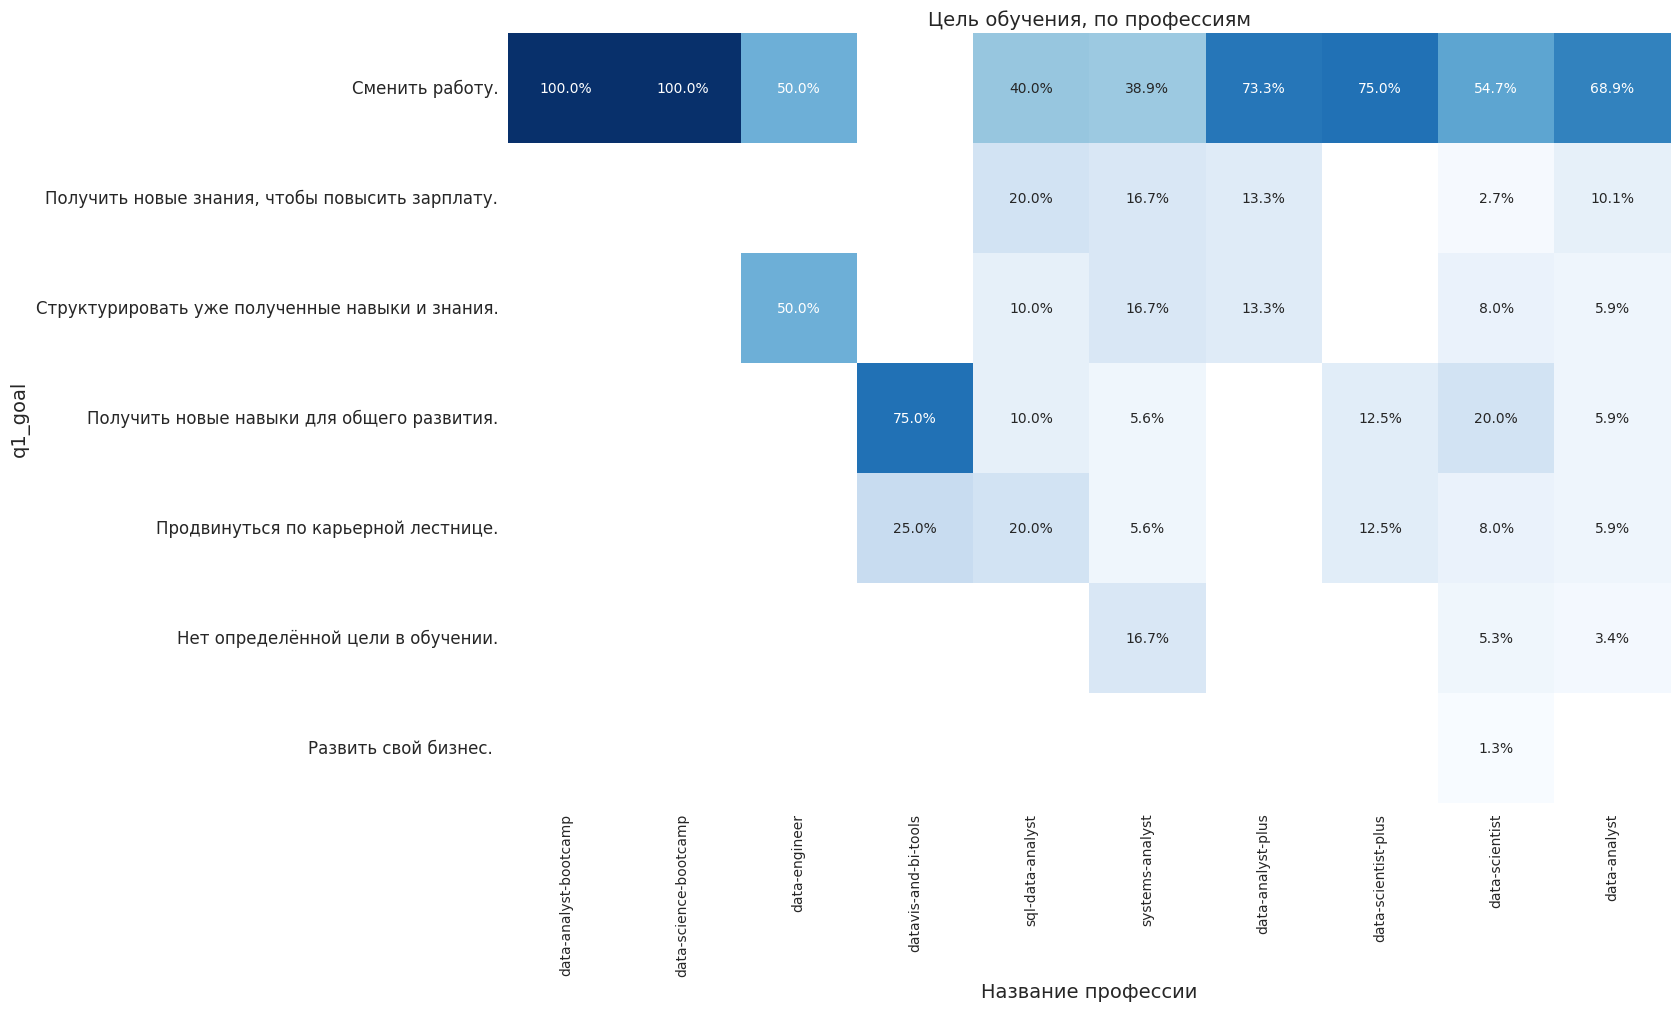

In [ ]:
heatmap_prof(data, 'q1_goal', 'Цель обучения, по профессиям', True)

Студенты курса по визуализации данных в первую очередь преследуют цель получить новые навыки для общего развития и продвинуться по карьерной лестнице. Для всех остальных первая цель - сменить работу.

Выраженные второстепенные цели: 
* для курса по SQL - продвинуться по карьерной лестнице и получить новые знания, чтобы повысить зарплату.
* для курса data-engineer - структурировать уже полученные навыки и знания
* для курса data-science - получить навыки для общего развития

Для остальных курсов нет выраженной втростепенной цели.

Рассмотрим опыт работы студентов в разрезе профессий. Впрочем, не будем забывать, что крайне мало студентов ответили на этот вопрос.

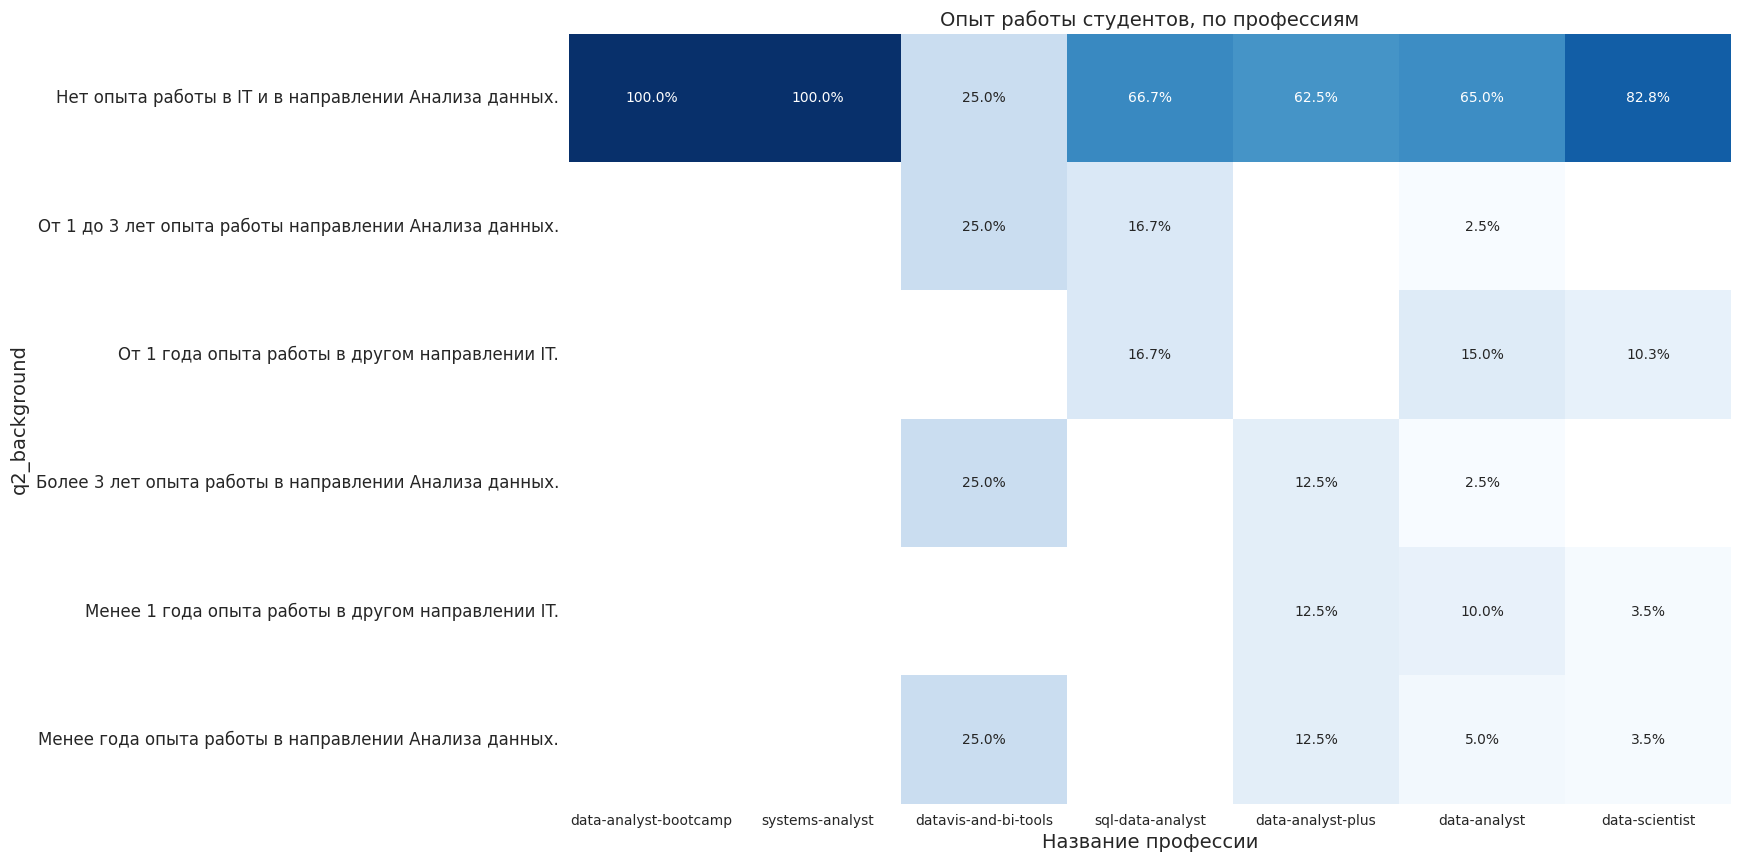

In [ ]:
heatmap_prof(data, 'q2_background', 'Опыт работы студентов, по профессиям', True)

Для всех профессий наибольшая доля студенов не имеют опыта работы в IT и в направлении Анализа данных.

Исключение - системные аналитики, курс по SQL и курс по визуализации, где больше людей с опытом.

Рассмотрим, как студенты разных профессий оценивают свои знания:

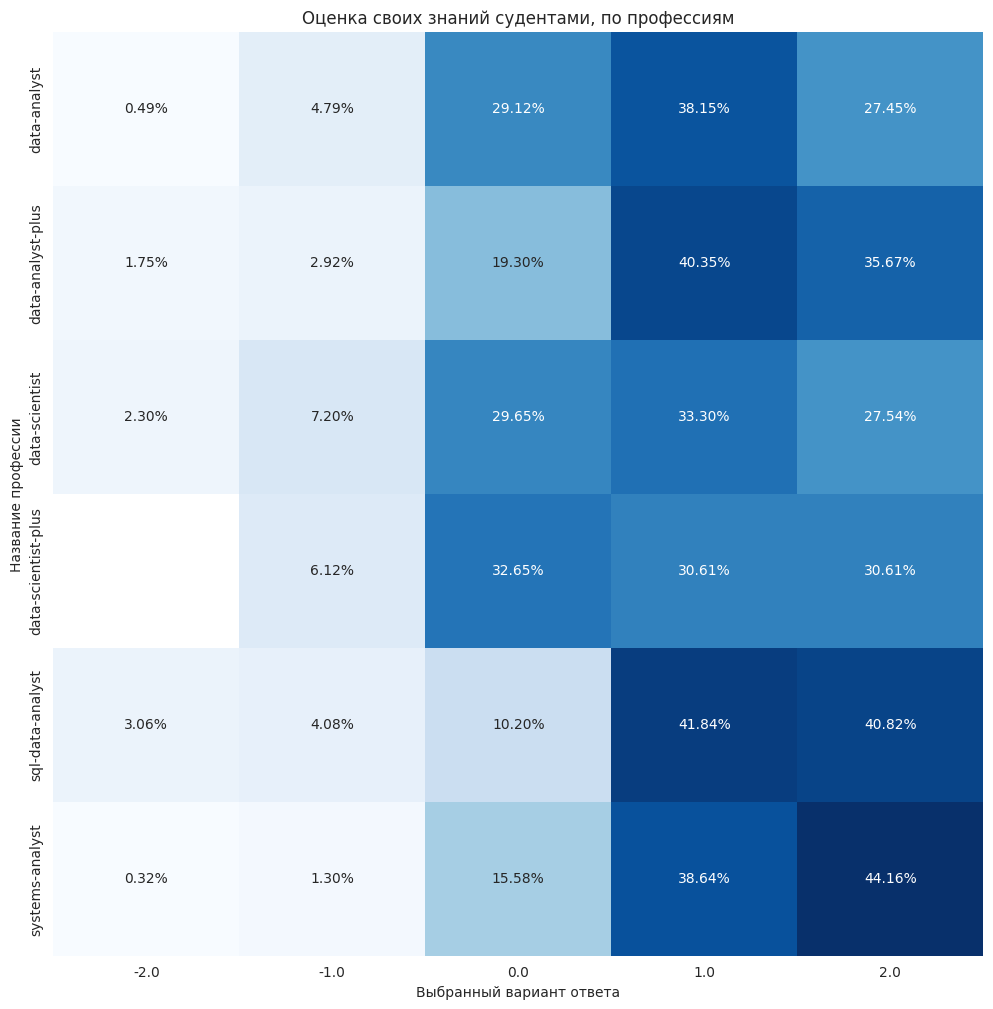

In [ ]:
prof_filter=['data-analyst', 'data-analyst-plus', 'data-scientist', 'data-scientist-plus', 'sql-data-analyst', 'systems-analyst']
for_heatmap=data.query('profession_name.isin(@prof_filter)').pivot_table(index='profession_name', columns='confidence', values='user_id', aggfunc='count')
for x in range(0,len(for_heatmap)):
  for_heatmap.iloc[x]=round(for_heatmap.iloc[x]/for_heatmap.iloc[x].sum(), 4)
plt.figure(figsize=(12,12))
sns.set_style('white')
#cmap=sns.light_palette("#5686E3", reverse=False, as_cmap=True)
sns.heatmap(for_heatmap, annot=True, cmap='Blues', fmt=".2%", cbar=False)
plt.title('Оценка своих знаний судентами, по профессиям')
plt.xlabel('Выбранный вариант ответа')
plt.ylabel('Название профессии')
plt.show()

Лучше всего прогрессс в своих знаниях оценивают студенты курсов **systems-analyst, sql-data-analyst** - скорее всего, курсы легки для усвоения навыков.

Вторые по уверенности - **data-analyst, data-analyst-plus**

Студенты курсов **data-science и data-science-plus** не так уверены в своём прогрессе в знаниях, видимо материал самый сложный среди аналитических профессий.

Сразу же посмотрим и на объективную оценку успеваемости - на коэффициент, выставленный студентам Практикумом. 

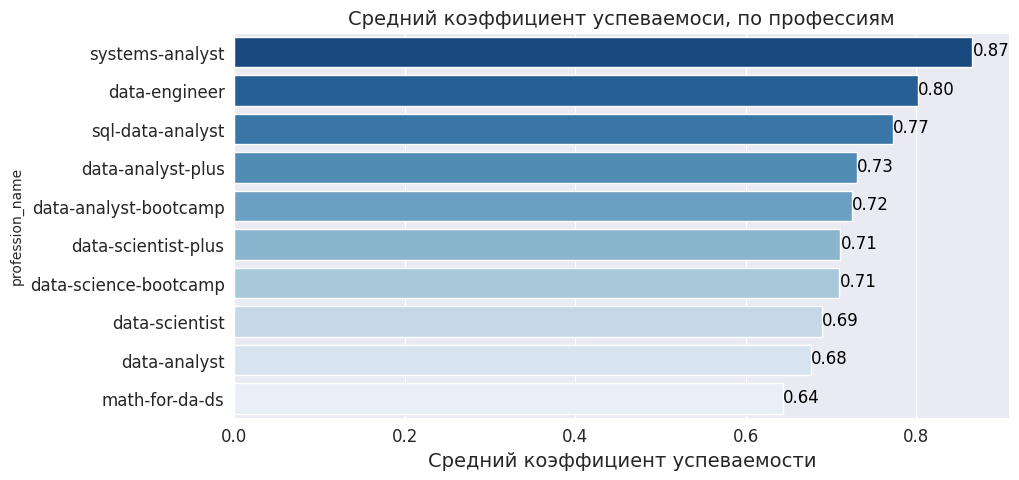

In [ ]:
prof_lp_avg = data.query('lp_avg_user.notna()').groupby('profession_name', as_index=False).agg({'lp_avg_user':'mean'}).sort_values(by='lp_avg_user', ascending=False)

plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
ax=sns.barplot(y=prof_lp_avg['profession_name'], x=prof_lp_avg['lp_avg_user'], orient='h', palette=("Blues_r"))
plt.title('Средний коэффициент успеваемоси, по профессиям', size=14)
plt.xlabel('Средний коэффициент успеваемости', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True, axis='x')
for p in ax.patches:
    percentage = '{:.2f}'.format(p.get_width())
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() - 0.3
    ax.annotate(percentage, (x, y), color='black', size = 12)
plt.show()

Объективно самые успевающие студенты - в профессиях **systems_analyst**, **data_engineer** и **sql_data_analyst**. Впрочем, от них не сильно отстают остальные профессии. Самые сложные для усвоения профессии: **math-for-da-ds**, **data-analyst**, **data-scientist**. Нет данных по курсу визуализации.

Посмотрим, готовы ли студенты рекомендовать курс. Здесь выведем только профессии, где количество оставивших фидбек не ниже 50, во избежание влияния фактора субъективности:

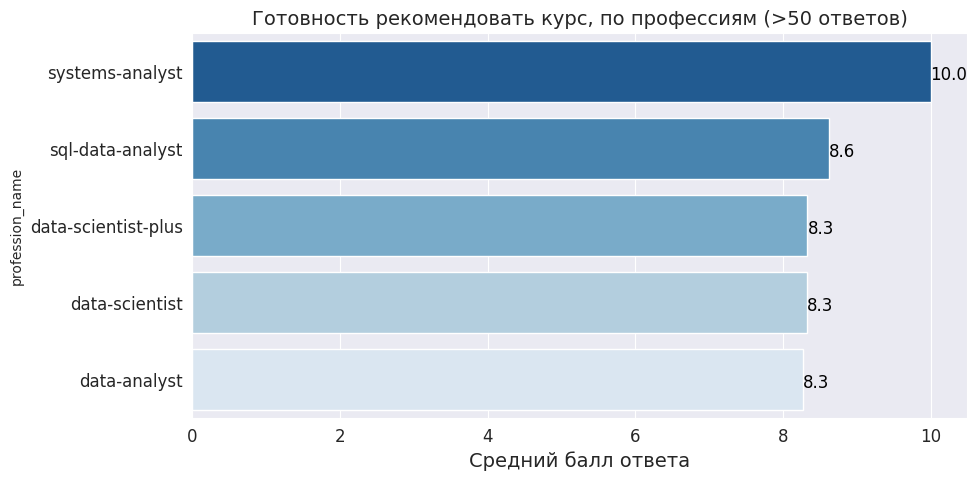

In [ ]:
prof_recom_rate = data.groupby('profession_name', as_index=False).agg({'recom_rate':'mean', 'user_id':'count'}).sort_values(by='recom_rate', ascending=False)

plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
ax=sns.barplot(y=prof_recom_rate.query('user_id >= 50 and recom_rate.notna()')['profession_name'], 
               x=prof_recom_rate.query('user_id >= 50 and recom_rate.notna()')['recom_rate'], orient='h', palette=("Blues_r"))
plt.title('Готовность рекомендовать курс, по профессиям (>50 ответов)', size=14)
plt.xlabel('Средний балл ответа', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True, axis='x')
for p in ax.patches:
    percentage = '{:.1f}'.format(p.get_width())
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() - 0.3
    ax.annotate(percentage, (x, y), color='black', size = 12)
plt.show()

Самые довольные студенты - с курса **systems-analyst**, у остальных средний балл сопоставим.

### 5.8 Портреты основных профессий <a name="eda_8"></a>

Соберём вместе основные характеристики профессиий с числом отвечавших на опросник студентов >100.

In [ ]:
#приводим основные показатели к процентной шкале 
prof_data=data.groupby('profession_name').agg({'user_id':'nunique',
                                                  'confidence':'mean',
                                                  'lp_avg_user':'mean','recom_rate':'mean'})
prof_data['confidence'] = prof_data['confidence']*50
prof_data['lp_avg_user'] = prof_data['lp_avg_user']*100
prof_data['recom_rate'] = prof_data['recom_rate']*10

#рассчитываем процент ответивших на вопрос о работе, по профессиям
prof_job=(data.pivot_table(index='profession_name', columns='q3_job_status', values='user_id', aggfunc='nunique')
          .reindex(columns=['Нет', 'В активном поиске', 'Да'])
)
for x in range(0,len(prof_job)):
  prof_job.iloc[x]=round(prof_job.iloc[x]*100/prof_job.iloc[x].sum(), 2)

#рассчитываем процент сменивших когорту, по профессиям
prof_coh_changed=(data.groupby('profession_name').agg({'cohort_changed':'sum'})
                      .rename(columns=({'cohort_changed':'changed'}))
                      .join(data.groupby('profession_name').agg({'cohort_changed':'count'}))
)
prof_coh_changed['percent']=prof_coh_changed['changed']*100/prof_coh_changed['cohort_changed']

#рассчитываем процент студентов в разных сегментах, по профессиям
prof_segment=data.pivot_table(index='profession_name', columns='current_segment', values='user_id', aggfunc='nunique')
for x in range(0,len(prof_segment)):
  prof_segment.iloc[x]=round(prof_segment.iloc[x]*100/prof_segment.iloc[x].sum(), 2)

#рассчитываем процент желающих сменить работу
prof_goal=(data.pivot_table(index='profession_name', columns='q1_goal', values='user_id', aggfunc='nunique')
     .join(data.query('q1_goal.notna()').groupby('profession_name').agg({'user_id':'nunique'})))
prof_goal['Цель - сменить работу']=(prof_goal['Сменить работу.']*100/prof_goal['user_id'])

#рассчитываем процент не имеющих опыта работы в IT
prof_background=(data.pivot_table(index='profession_name', columns='q2_background', values='user_id', aggfunc='nunique')
     .join(data.query('q2_background.notna()').groupby('profession_name').agg({'user_id':'nunique'})))
prof_background['Есть опыт']=100-(prof_background['Нет опыта работы в IT и в направлении Анализа данных.']*100/prof_background['user_id'])

#соединяем таблицы по профессиям, переименовываем столбцы
prof_data = (prof_data.join(prof_job)
                      .join(prof_segment)
                      .join(prof_coh_changed['percent'])
                      .join(prof_goal['Цель - сменить работу'])
                      .join(prof_background['Есть опыт'])
).rename(columns=({'Нет': 'Не нашли работу во время учёбы',
                           'В активном поиске работы': 'В активном поиске',
                           'Да': 'Нашли работу во время учёбы',
                           'user_id':'users_count',
                           'confidence':'Уверены в своих знаниях',
                           'lp_avg_user':'Коэффициент успеваемости',
                           'recom_rate':'Готовы рекомендовать курс',
                           'percent':'Брали академ',
                           'b2g':'Из "Цифровых профессий"'}))

Визуализируем основные характеристики каждой профессии отдельно.

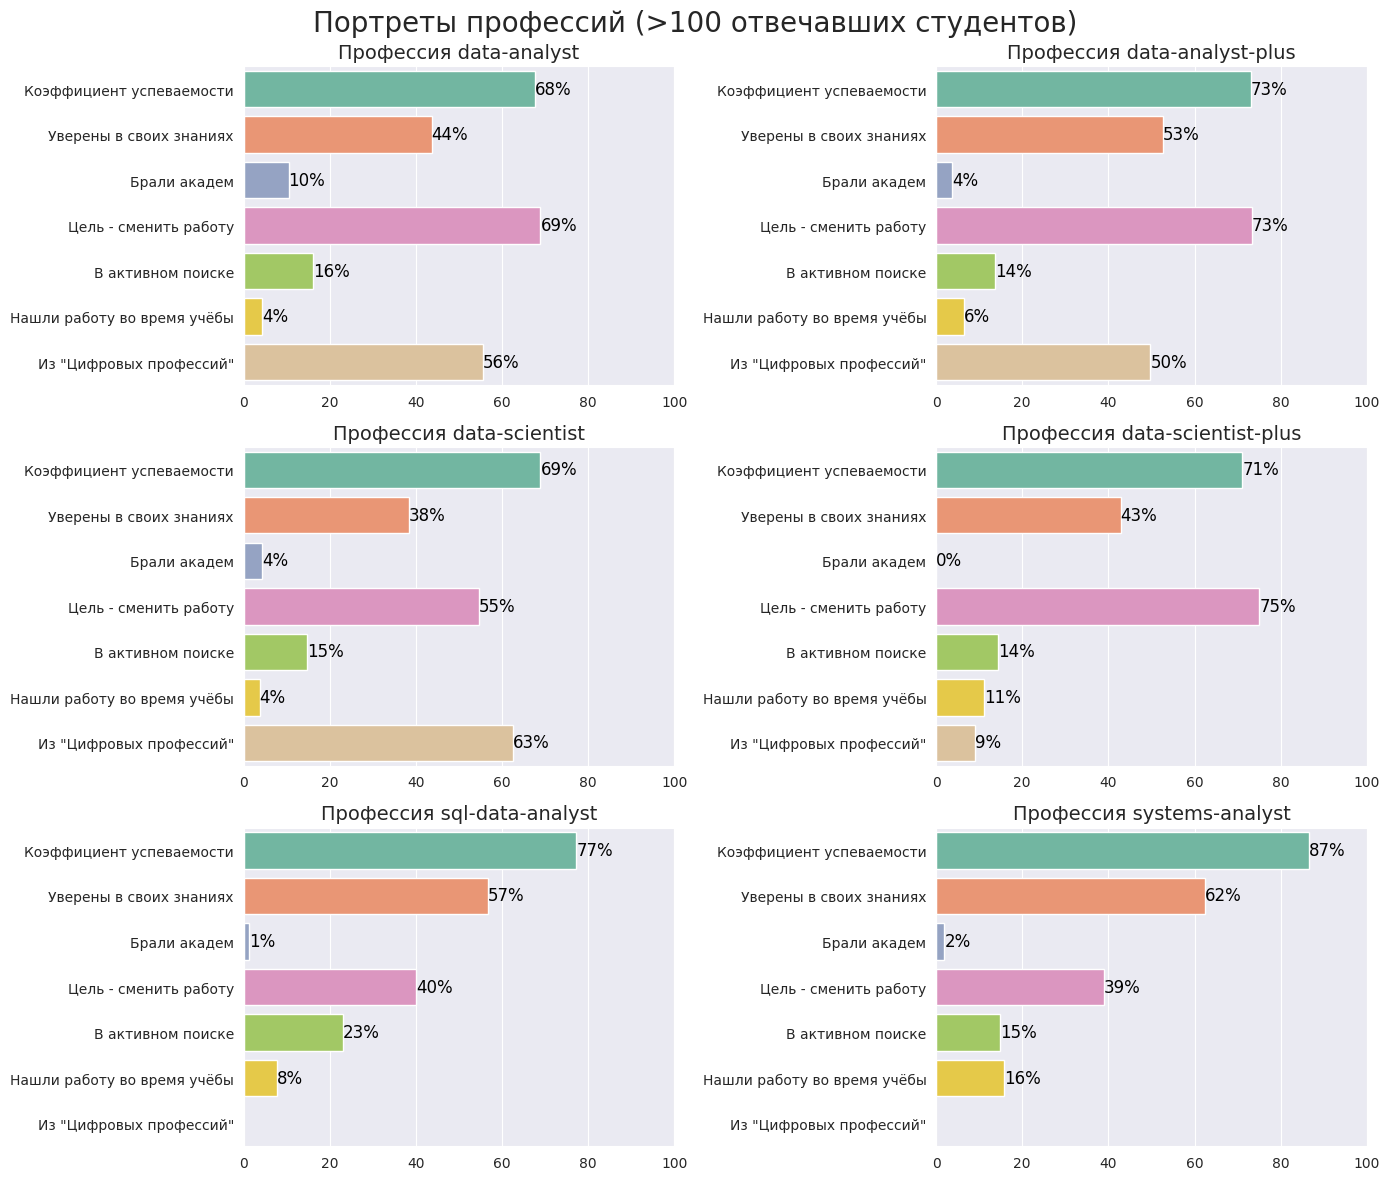

In [ ]:
location=[321, 322, 323, 324, 325, 326]
professions=(data.groupby('profession_name', as_index=False).agg({'user_id':'nunique'})
                 .query('user_id>100')['profession_name']
             )

plt.figure(figsize=(14, 12))
for prof, number in zip(professions, location):
  plt.subplot(number)
  ax=sns.barplot(data=prof_data.query('profession_name == @prof')[['Коэффициент успеваемости',
                                                              'Уверены в своих знаниях',
                                                              'Брали академ',
                                                              'Цель - сменить работу',
                                                              'В активном поиске', 
                                                              'Нашли работу во время учёбы',
                                                              'Из "Цифровых профессий"']], palette='Set2', orient='horizontal')
  for p in ax.patches:
    percentage = '{:.0f}%'.format(p.get_width())
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() - 0.3
    ax.annotate(percentage, (x, y), color='black', size = 12)
  ax.set_xlim(0,100)
  plt.grid(True, axis='x')
  plt.title(f'Профессия {prof}', size=14)
plt.suptitle('Портреты профессий (>100 отвечавших студентов)', fontsize=20)
plt.tight_layout()
plt.show()

**Выводы** после сравнения между собой самых популярных профессий:   

**Специалист по Data Science:**   
* Самый высокий процент студентов с гос.софинансированием (63%), 
* Из профессий с гос.софинансированием самый низкий процент тех, кто песледует главную цель сменить работу (55%).   
* Как и в профессии Аналитик Данных, самый низкий процент нашедших работу во время учёбы (4%). Если сравнить с программой "Плюс", в последней он почти в три раза больше (11%).
* Самый низкий процент уверенных в своих знаниях студентов (38%), можно сравнить с программой "Плюс", где уверенных 43%. Один из самых низких коэффициентов успеваемости 68% (наряду с профессией "Аналитик данных") это подтверждает.

Программа, скорее всего, сложная: студенты не чувствуют уверенности в своих знаниях, им трудно устраиваться на работу.

**Специалист по Data Science Плюс:**
По сравнению с обычной программой:
* Самый малый процент студентов с гос.софинансированием из тех профессий, где она была (9%)
* На два процентных пункта выше коэффициент успеваемости (71%)
* Уверены в своих знаниях на 5 процентных пункта больше студентов (43% студентов, но тоже процент не высокий)
* Нет бравших академ студентов
* Сменить работу преследует цель 75% студентов - самый высокий процент среди всех основных профессий
* В три раза больше процент нашедших работу во время обучения (11%)   

Видимо, студенты чувствуют себя несколько увереннее, чем в обычной программе, и гораздо быстрее находят работу.

**Аналитик данных:**
* Самый низкий коэффициент успеваемости (68%), сравним с профессией "Специалист по Data Science* (69%), но при этом уверенность студентов в своих знаниях выше - 44% против 38%
* Самый высокий процент бравших академ студентов - каждый десятый.
* Один из самых высоких процентов по цели обучения "смена работы" - 69% студентов
* Наряду с профессией "Специалист по Data Science", самый низкий процент нашедших работу во время обучения (4%)   

Вопреки распространённому мнению, наши данные говорят о том, что профессия не проще в усвоении, чем "Специалист по Data Science", здесь даже больше студентов, которые не успевают её осваивать, находят работу студенты так же тяжело. Тем не менее, чувствуют себя увереннее в собственных знаниях, чем в Data Science - возможно, это связано с отсутствием столь высоких требований к знаниям математики. 

**Аналитик данных плюс:**
По сравнению с обычной программой
* Коэффициент успеваемости выше на 5 процентных пунктов. Студенты реже берут акадм (4% против 10% в обычной программе)
* На 9% выше процент уверенных в своих знаниях (53%, самый высокий показатель среди всех профессий, которые участвовали в программе гос.софинансирования)
* На 2 процентных пункта больше студентов, которые нашли работу во время учёбы. Процент всё же невысокий.   

Студенты здесь увереннее, чем в обычной программе, лучше усваивают программу, реже берут академы, но на работу устраиваются лишь немногим легче. Если сравнивать с Data Science, где с ростом уверенности в знаниях растёт и возможность трудоустройства, возможно, здесь сложнее трудоустроиться скорее из-за высокой конкуренции: аналитиков данных среди выпускников аналитических профессий - самое большое количество.

**SQL для анализа данных:**
* Осваивают программу студенты очень хорошо (77%) и почти не брали академы (1%)
* Студенты весьма уверены в своих знаниях (57%)
* Цель сменить работу преследуют только 40% студентов - один из самых низких показателей.
* Тем не менее, в активном поиске её 23% и 8% нашли работу во время учёбы.   

Программа достаточно проста в усвоении, скорее всего её проходят либо чтобы подтянуть знания, либо как первую ступень на пути к анализу данных - отсюда возможно и идёт самый маленький процент желающих сменить работу, но в то же время больше всего других профессий тех, кто в активом поиске или нашёл работу во время учёбы.

**Профессия Системный аналитик:**
* Самый высокий коэффициент успеваемости - 87%, студенты почти не берут академы (2%)
* Уверены в своих знаниях 62% студентов, самый высокий показатель
* Цель сменить работу преследуют 39% студентов, самый низкий показатель
* В то же время в активном поиске 15% студентов (обычный показатель), а нашедших работу во время учёбы - 16% студентов (самый высокий среди основных профессий)

Материал студенты усваивают легче, чем в других профессиях, и они уверенне других в своих знаниях. К сожалению, очень мало студентов ответили на вопрос об опыте работы, но мы можем предположить, что сюда идёт больше людей с опытом, отсюда меньше людей, пришедших за сменой работы. В то же время, находят работу здесь студенты легче, чем остальных основных профессиях. Самая позитивная история.

## 6. Общие выводы <a name="concl"></a>

**Выводы предобработки**

* Студенты часто пропускают вопросы, не отвечая на них.
* Студенты отвечают на вопросы регуляно, в этом случае мы в анализе учитываем последний ответ.
* Один студент может одновременно обучаться нескольким профессиям, в этом случае мы учитываем последние ответы студента по каждой профессии.

**Выводы исследовательского анализа**

* Больше всего студентов учатся на направлениях data analyst и data scientist.
* Средняя оценка готовности порекомендовать курс увеличивается с ростом уверенности студента в своих знаниях.
* Самые объемные сегменты b2g и b2c. B2b практически не представлен (возможно, b2b не даёт возможности своим сотрудникам поступать на курс "Трудоустройство").
* Большая часть студентов (95.2%) остались учиться до поступления на курс "Трудоустройство" в b2g, небольшая часть (4.8%) перешли в b2c. Такой переход предположительно связан с невыполненим студентами условий государственой программы, в связи с чем они были вынуждены опатить курс самостоятельно и подолжать его уже в сегменте b2c.
* Cлучаи перехода из b2g в b2c ещё более редки. Большая часть студентов, поменявших сегмент, участся профессии data-analyst, немногим меньше - data-scientist.
* Самые довольные студенты - с курса systems-analyst, у остальных средний балл сопоставим.

**Выводы из ответов пользователей на вопросы**

* Большая часть студентов записывалась на курс, чтобы сменить работу. И нет ни одного студента, который бы записывался на курс, чтобы развить свой бизнес.
* Большая часть студентов записывается на курсы, не имея опыта работы в IT или с минимальным опытом в другом направлении IT.
* Большая часть студентов на курсе "Трудоустройство" ещё не устроились на работу.
* На карьерный трек большая часть студентов курса или уже записались, или планируют записаться по окончании диплома (последний вариант популярнее).
* Большая часть студентов, ответивших на соответствующий вопрос, готовы рекомендовать курс. Однако число ответивших небольшое и поскольку студенты сами решали, отвечать на него или нет, ответы могут быть нерелевантными
* Большая часть студентов уверены в своих знаниях
* В текстовых комментариях основном люди пишут о том, нашли или не нашли работу (короткие комментарии), либо расшириют ответы, данные ранее в опроснике. Возможно, в дальнейшем стоит провести отдельное исследование многосимвольных комментариев, которое позволит, исходя из ответов пользователей и их содержательных комментариев, вынести выводы об их основных потребностях в курсе, что может быть полезно для будущей коррекции опросника.

**Что интересует пользователей**

В целом студентов больше всего интересуют практические навыки прохождения этапов трудоустройства, такие как:
- составлению резюме
- портфолио
- прохождению собеседований
- решение тестовых заданий 
- написание сопроводительных писем

Меньше интересуют стратегические вопросы:
- оценка шансов на трудоустройство
- определение стратегии поиска работы
- персональная карьерная консультация

Меньше всего студентов интересуют более общие вопросы:
- как и куда расти как специалисту
- устройство рынка труда
- определение профессиональной сферы
- как говорить про повышение

Радует, что студенты настроены позитивно: вариант "не думаю, что вы можете мне с чем-то помочь" выбран наименьшим числом студентов.

**Выводы по основным профессиям**

* **Специалист по Data Science**: Программа сложная: студенты не чувствуют уверенности в своих знаниях, им трудно устраиваться на работу.
* **Специалист по Data Science Плюс**: По сравнению с обычной программой студенты чувствуют себя несколько увереннее, чем в обычной программе. С ростом компетенций, которыми здесь удаётся овладеть в более полной мере, растёт и процент трудоустроенных за время обучения (12% против 4% в обычной программе)

* **Аналитик данных**: Вопреки распространённому мнению, данные говорят о том, что студентам здесь не проще, чем в Data Science: даже ещё больше студентов, которые не успевают осваивать программу, находят работу студенты так же тяжело (4% трудоустроенных за время обучения). Тем не менее, студенты в собственных знаниях здесь увереннее, чем в Data Science - возможно, это связано с отсутствием столь высоких требований к знаниям математики. 

* **Аналитик данных плюс**: Студенты здесь увереннее, чем в обычной программе, лучше усваивают программу, реже берут академы, но на работу устраиваются лишь немногим легче. Если сравнивать с Data Science, где с ростом уверенности в знаниях растёт и возможность трудоустройства, возможно, здесь сложнее трудоустроиться скорее из-за высокой конкуренции: аналитиков данных среди выпускников проанализированных нами профессий - самое большое количество.

* **SQL для анализа данных**: Программа проста в усвоении, скорее всего её проходят чтобы подтянуть знания, отсюда возможно и идёт самый маленький процент желающих сменить работу, но в то же время в сравнении с другими профессиями больше тех, кто в активом поиске или нашёл работу во время учёбы.

* **Системный аналитик**: Материал студенты усваивают легче, чем в других профессиях, и они уверенне других в своих знаниях. К сожалению, очень мало студентов ответили на вопрос об опыте работы, но мы можем предположить, что сюда идёт больше людей с опытом, отсюда меньше людей, пришедших за сменой работы. В то же время, находят работу здесь студенты легче, чем остальных основных профессиях. Самая позитивная история.

**Выводы из сегментации пользователей**

 * Самый *распространенный* сегмент пользователей "Яндекс Практикума" представляют люди без опыта в ИТ и изучаемой профессии, которые хотели бы сменить работу. Подавляющее большинство студентов **DA, DS, DA-plus, DS-plus** являются представителями данного сегмента.
 * Выделяются пользователи, которые не планируют менять работу и пользоваться услугами карьерного трека. Их основная задача - структурировать знания и добиться повышения з/п на текущем месте работы. Большое количество пользователей данного типа обучаются по направлению **Systems Analyst**.
 * Третий тип пользователей отличается наличием опыта работы по выбранной специальности и тем, что их главной задачей является продвижение по карьере и повышение з/п. В отличие от представителей второго сегмента, студенты из данной категории готовы сменить место работы и зарегистрироваться в карьерном треке. Существенная доля пользователей из данного сегмента обучается по направлениям **Визуализация данных** и **SQL Data Analyst**. В то же время, из ответов на вопросы студентов последнего следует, что они больше заинтересованы в "стратегических" вопросах: "оценка шансов на трудоустройство" и "опредление стратегии поиска работы". Процент ответа "не думаю, что вы можете мне с чем-то помочь" самый высокий по сравнению с другими профессиями. Видимо, выпускники этого курса чувствуют себя менее уверенно в вопросах трудоустройства.